# Twitter Sentiment Analysis

In [1]:
# Suppress warnings about too few trees from the early models

import warnings # we can use this anywhere to ignore wargnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in c:\users\dell\anaconda3\lib\site-packages (3.7.3)
Requirement already up-to-date: keras in c:\users\dell\anaconda3\lib\site-packages (2.2.4)
Requirement already up-to-date: pandas in c:\users\dell\anaconda3\lib\site-packages (0.24.2)


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

C:\Users\dell\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [6]:
# Word2vec
import gensim

In [7]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [8]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Settings

In [10]:
## DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

In [11]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [12]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [13]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

In [14]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [15]:
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [16]:
dataset_filename = os.listdir("training.1600000.processed.noemoticon.csv")[0]
dataset_path = os.path.join("training.1600000.processed.noemoticon.csv",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: training.1600000.processed.noemoticon.csv\training.1600000.processed.noemoticon.csv


In [17]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [18]:
df.shape()

TypeError: 'tuple' object is not callable

In [19]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [20]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [21]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.19 s


Counter({'NEGATIVE': 800000, 'POSITIVE': 800000})


Text(0.5,1,'Dataset labels distribuition')

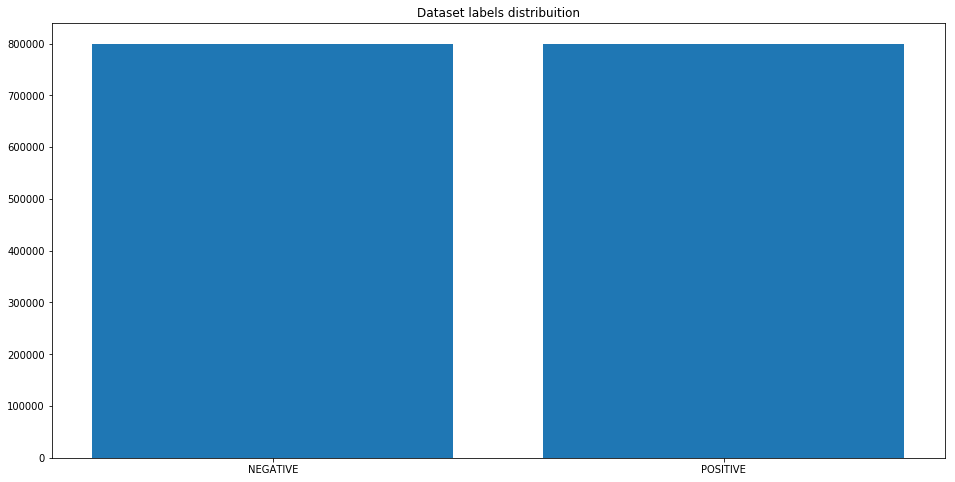

In [47]:
target_cnt = Counter(df.target)
print(target_cnt)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [22]:
stop_words = stopwords.words("english")

In [23]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [50]:
stemmer = SnowballStemmer("english")

In [51]:
dir(stemmer)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 'languages',
 'stem',
 'stemmer',
 'stopwords']

In [24]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 40s


### Split train and test

In [26]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [27]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.15 s


In [28]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [29]:
w2v_model.build_vocab(documents)

2019-07-07 14:53:32,416 : INFO : collecting all words and their counts
2019-07-07 14:53:32,417 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-07-07 14:53:32,450 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-07-07 14:53:32,478 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-07-07 14:53:32,514 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-07-07 14:53:32,543 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-07-07 14:53:32,573 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-07-07 14:53:32,603 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-07-07 14:53:32,640 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-07-07 14:53:32,665 : INFO : PROGRESS: at s

2019-07-07 14:53:34,662 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2019-07-07 14:53:34,697 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2019-07-07 14:53:34,725 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2019-07-07 14:53:34,756 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2019-07-07 14:53:34,789 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2019-07-07 14:53:34,822 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2019-07-07 14:53:34,854 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2019-07-07 14:53:34,883 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2019-07-07 14:53:34,911 : INFO : PROGRESS: at sentence #800000, processed 577088

In [30]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-07-07 15:15:05,263 : WARNING : Effective 'alpha' higher than previous training cycles
2019-07-07 15:15:05,265 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-07-07 15:16:03,782 : INFO : EPOCH 1 - PROGRESS: at 0.11% examples, 152 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:16:04,951 : INFO : EPOCH 1 - PROGRESS: at 0.75% examples, 1050 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:17:07,450 : INFO : EPOCH 1 - PROGRESS: at 0.97% examples, 657 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:17:08,531 : INFO : EPOCH 1 - PROGRESS: at 1.62% examples, 1086 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:18:02,971 : INFO : EPOCH 1 - PROGRESS: at 1.84% examples, 854 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:18:33,084 : INFO : EPOCH 1 - PROGRESS: at 2.71% examples, 1073 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:19:02,048 : INFO : EPOCH 1 - PROGRESS: at 3.58% examples, 1243 words/s, in_qsize 1

2019-07-07 15:31:12,978 : INFO : EPOCH 1 - PROGRESS: at 25.91% examples, 2201 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:31:14,659 : INFO : EPOCH 1 - PROGRESS: at 26.02% examples, 2206 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:31:40,031 : INFO : EPOCH 1 - PROGRESS: at 26.12% examples, 2159 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:31:41,086 : INFO : EPOCH 1 - PROGRESS: at 26.23% examples, 2166 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:31:42,312 : INFO : EPOCH 1 - PROGRESS: at 26.67% examples, 2199 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:31:44,810 : INFO : EPOCH 1 - PROGRESS: at 26.88% examples, 2211 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:32:10,482 : INFO : EPOCH 1 - PROGRESS: at 26.99% examples, 2164 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:32:11,485 : INFO : EPOCH 1 - PROGRESS: at 27.20% examples, 2179 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:32:12,666 : INFO : EPOCH 1 - PROGRESS: at 27.53% examples, 2203 words/s, in_qsize 16, out_

2019-07-07 15:40:36,346 : INFO : EPOCH 1 - PROGRESS: at 41.70% examples, 2240 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:40:37,825 : INFO : EPOCH 1 - PROGRESS: at 42.02% examples, 2256 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:40:38,908 : INFO : EPOCH 1 - PROGRESS: at 42.35% examples, 2271 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:40:42,300 : INFO : EPOCH 1 - PROGRESS: at 42.46% examples, 2272 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:41:05,179 : INFO : EPOCH 1 - PROGRESS: at 42.57% examples, 2245 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:41:06,202 : INFO : EPOCH 1 - PROGRESS: at 42.78% examples, 2255 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:41:07,224 : INFO : EPOCH 1 - PROGRESS: at 43.00% examples, 2264 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:41:11,373 : INFO : EPOCH 1 - PROGRESS: at 43.32% examples, 2276 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:41:36,744 : INFO : EPOCH 1 - PROGRESS: at 43.43% examples, 2245 words/s, in_qsize 15, out_

2019-07-07 15:49:32,960 : INFO : EPOCH 1 - PROGRESS: at 56.62% examples, 2254 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:49:34,057 : INFO : EPOCH 1 - PROGRESS: at 56.95% examples, 2265 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:49:35,075 : INFO : EPOCH 1 - PROGRESS: at 57.06% examples, 2269 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:49:39,214 : INFO : EPOCH 1 - PROGRESS: at 57.16% examples, 2268 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:50:02,033 : INFO : EPOCH 1 - PROGRESS: at 57.27% examples, 2248 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:50:03,441 : INFO : EPOCH 1 - PROGRESS: at 57.49% examples, 2255 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:50:04,701 : INFO : EPOCH 1 - PROGRESS: at 57.81% examples, 2266 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:50:06,040 : INFO : EPOCH 1 - PROGRESS: at 57.92% examples, 2269 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:50:10,710 : INFO : EPOCH 1 - PROGRESS: at 58.03% examples, 2268 words/s, in_qsize 15, out_

2019-07-07 15:56:52,146 : INFO : EPOCH 1 - PROGRESS: at 69.61% examples, 2285 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:56:53,427 : INFO : EPOCH 1 - PROGRESS: at 69.83% examples, 2291 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:56:54,461 : INFO : EPOCH 1 - PROGRESS: at 69.94% examples, 2294 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:56:58,942 : INFO : EPOCH 1 - PROGRESS: at 70.05% examples, 2293 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:57:03,438 : INFO : EPOCH 1 - PROGRESS: at 70.16% examples, 2293 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:57:28,925 : INFO : EPOCH 1 - PROGRESS: at 70.26% examples, 2273 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:57:30,016 : INFO : EPOCH 1 - PROGRESS: at 70.48% examples, 2279 words/s, in_qsize 16, out_qsize 0
2019-07-07 15:57:31,337 : INFO : EPOCH 1 - PROGRESS: at 70.70% examples, 2285 words/s, in_qsize 15, out_qsize 0
2019-07-07 15:57:32,341 : INFO : EPOCH 1 - PROGRESS: at 70.80% examples, 2288 words/s, in_qsize 16, out_

2019-07-07 16:03:55,025 : INFO : EPOCH 1 - PROGRESS: at 81.88% examples, 2299 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:03:58,372 : INFO : EPOCH 1 - PROGRESS: at 82.21% examples, 2306 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:04:02,694 : INFO : EPOCH 1 - PROGRESS: at 82.32% examples, 2305 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:04:20,881 : INFO : EPOCH 1 - PROGRESS: at 82.42% examples, 2294 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:04:21,919 : INFO : EPOCH 1 - PROGRESS: at 82.64% examples, 2299 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:04:23,037 : INFO : EPOCH 1 - PROGRESS: at 82.74% examples, 2301 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:04:26,526 : INFO : EPOCH 1 - PROGRESS: at 83.07% examples, 2308 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:04:30,776 : INFO : EPOCH 1 - PROGRESS: at 83.18% examples, 2307 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:04:49,203 : INFO : EPOCH 1 - PROGRESS: at 83.29% examples, 2296 words/s, in_qsize 15, out_

2019-07-07 16:11:19,592 : INFO : EPOCH 1 - PROGRESS: at 94.79% examples, 2310 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:11:21,409 : INFO : EPOCH 1 - PROGRESS: at 94.91% examples, 2311 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:11:22,679 : INFO : EPOCH 1 - PROGRESS: at 95.12% examples, 2316 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:11:25,771 : INFO : EPOCH 1 - PROGRESS: at 95.23% examples, 2316 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:11:31,065 : INFO : EPOCH 1 - PROGRESS: at 95.34% examples, 2315 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:11:48,986 : INFO : EPOCH 1 - PROGRESS: at 95.45% examples, 2306 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:11:51,574 : INFO : EPOCH 1 - PROGRESS: at 95.77% examples, 2312 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:11:53,058 : INFO : EPOCH 1 - PROGRESS: at 95.99% examples, 2316 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:11:56,203 : INFO : EPOCH 1 - PROGRESS: at 96.10% examples, 2317 words/s, in_qsize 16, out_

2019-07-07 16:22:05,076 : INFO : EPOCH 2 - PROGRESS: at 14.43% examples, 2436 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:22:32,665 : INFO : EPOCH 2 - PROGRESS: at 14.86% examples, 2375 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:22:34,163 : INFO : EPOCH 2 - PROGRESS: at 15.30% examples, 2437 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:23:01,293 : INFO : EPOCH 2 - PROGRESS: at 15.73% examples, 2381 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:23:02,855 : INFO : EPOCH 2 - PROGRESS: at 16.16% examples, 2439 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:23:03,868 : INFO : EPOCH 2 - PROGRESS: at 16.48% examples, 2484 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:23:29,264 : INFO : EPOCH 2 - PROGRESS: at 16.59% examples, 2389 words/s, in_qsize 16, out_qsize 0
2019-07-07 16:23:31,074 : INFO : EPOCH 2 - PROGRESS: at 17.02% examples, 2443 words/s, in_qsize 15, out_qsize 0
2019-07-07 16:23:57,728 : INFO : EPOCH 2 - PROGRESS: at 17.46% examples, 2394 words/s, in_qsize 15, out_

2019-07-07 19:52:49,576 : INFO : EPOCH 2 - PROGRESS: at 30.89% examples, 193 words/s, in_qsize 15, out_qsize 0
2019-07-07 19:52:51,098 : INFO : EPOCH 2 - PROGRESS: at 30.99% examples, 194 words/s, in_qsize 15, out_qsize 0
2019-07-07 19:52:58,324 : INFO : EPOCH 2 - PROGRESS: at 31.21% examples, 195 words/s, in_qsize 16, out_qsize 0
2019-07-07 19:53:51,655 : INFO : EPOCH 2 - PROGRESS: at 31.32% examples, 195 words/s, in_qsize 16, out_qsize 0
2019-07-07 19:53:55,624 : INFO : EPOCH 2 - PROGRESS: at 31.42% examples, 196 words/s, in_qsize 16, out_qsize 0
2019-07-07 19:53:57,374 : INFO : EPOCH 2 - PROGRESS: at 31.86% examples, 198 words/s, in_qsize 15, out_qsize 0
2019-07-07 19:54:04,034 : INFO : EPOCH 2 - PROGRESS: at 32.08% examples, 200 words/s, in_qsize 15, out_qsize 0
2019-07-07 19:55:06,606 : INFO : EPOCH 2 - PROGRESS: at 32.19% examples, 199 words/s, in_qsize 16, out_qsize 0
2019-07-07 19:55:10,785 : INFO : EPOCH 2 - PROGRESS: at 32.30% examples, 200 words/s, in_qsize 15, out_qsize 0
2

2019-07-07 20:11:22,576 : INFO : EPOCH 2 - PROGRESS: at 44.51% examples, 257 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:11:23,986 : INFO : EPOCH 2 - PROGRESS: at 44.73% examples, 258 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:11:29,645 : INFO : EPOCH 2 - PROGRESS: at 45.05% examples, 260 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:12:24,528 : INFO : EPOCH 2 - PROGRESS: at 45.16% examples, 260 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:12:29,891 : INFO : EPOCH 2 - PROGRESS: at 45.26% examples, 260 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:12:31,862 : INFO : EPOCH 2 - PROGRESS: at 45.48% examples, 261 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:12:33,011 : INFO : EPOCH 2 - PROGRESS: at 45.81% examples, 263 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:12:37,789 : INFO : EPOCH 2 - PROGRESS: at 45.92% examples, 264 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:13:35,830 : INFO : EPOCH 2 - PROGRESS: at 46.02% examples, 263 words/s, in_qsize 15, out_qsize 0
2

2019-07-07 20:22:18,267 : INFO : EPOCH 2 - PROGRESS: at 59.12% examples, 327 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:22:19,316 : INFO : EPOCH 2 - PROGRESS: at 59.44% examples, 328 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:22:22,275 : INFO : EPOCH 2 - PROGRESS: at 59.76% examples, 330 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:22:44,488 : INFO : EPOCH 2 - PROGRESS: at 59.87% examples, 330 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:22:47,030 : INFO : EPOCH 2 - PROGRESS: at 59.98% examples, 331 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:22:48,033 : INFO : EPOCH 2 - PROGRESS: at 60.30% examples, 332 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:22:51,035 : INFO : EPOCH 2 - PROGRESS: at 60.63% examples, 334 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:23:14,914 : INFO : EPOCH 2 - PROGRESS: at 60.74% examples, 334 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:23:17,590 : INFO : EPOCH 2 - PROGRESS: at 60.85% examples, 335 words/s, in_qsize 15, out_qsize 0
2

2019-07-07 20:31:13,932 : INFO : EPOCH 2 - PROGRESS: at 72.10% examples, 384 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:31:15,040 : INFO : EPOCH 2 - PROGRESS: at 72.43% examples, 386 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:31:16,043 : INFO : EPOCH 2 - PROGRESS: at 72.64% examples, 387 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:31:19,070 : INFO : EPOCH 2 - PROGRESS: at 72.75% examples, 388 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:31:41,712 : INFO : EPOCH 2 - PROGRESS: at 72.86% examples, 388 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:31:43,944 : INFO : EPOCH 2 - PROGRESS: at 72.97% examples, 388 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:31:45,153 : INFO : EPOCH 2 - PROGRESS: at 73.19% examples, 389 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:31:46,557 : INFO : EPOCH 2 - PROGRESS: at 73.52% examples, 391 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:31:49,478 : INFO : EPOCH 2 - PROGRESS: at 73.62% examples, 392 words/s, in_qsize 16, out_qsize 0
2

2019-07-07 20:38:23,378 : INFO : EPOCH 2 - PROGRESS: at 85.02% examples, 441 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:38:25,617 : INFO : EPOCH 2 - PROGRESS: at 85.13% examples, 441 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:38:26,654 : INFO : EPOCH 2 - PROGRESS: at 85.23% examples, 442 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:38:27,795 : INFO : EPOCH 2 - PROGRESS: at 85.45% examples, 443 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:38:32,252 : INFO : EPOCH 2 - PROGRESS: at 85.77% examples, 444 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:38:51,196 : INFO : EPOCH 2 - PROGRESS: at 85.88% examples, 445 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:38:53,288 : INFO : EPOCH 2 - PROGRESS: at 85.99% examples, 445 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:38:55,018 : INFO : EPOCH 2 - PROGRESS: at 86.21% examples, 446 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:38:56,393 : INFO : EPOCH 2 - PROGRESS: at 86.53% examples, 448 words/s, in_qsize 16, out_qsize 0
2

2019-07-07 20:45:07,160 : INFO : EPOCH 2 - PROGRESS: at 97.29% examples, 492 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:45:08,464 : INFO : EPOCH 2 - PROGRESS: at 97.39% examples, 492 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:45:10,178 : INFO : EPOCH 2 - PROGRESS: at 97.71% examples, 494 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:45:15,198 : INFO : EPOCH 2 - PROGRESS: at 97.93% examples, 495 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:45:33,925 : INFO : EPOCH 2 - PROGRESS: at 98.04% examples, 495 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:45:35,842 : INFO : EPOCH 2 - PROGRESS: at 98.15% examples, 495 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:45:37,008 : INFO : EPOCH 2 - PROGRESS: at 98.25% examples, 496 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:45:38,140 : INFO : EPOCH 2 - PROGRESS: at 98.47% examples, 497 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:45:43,619 : INFO : EPOCH 2 - PROGRESS: at 98.79% examples, 498 words/s, in_qsize 12, out_qsize 0
2

2019-07-07 20:58:35,959 : INFO : EPOCH 3 - PROGRESS: at 21.14% examples, 2349 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:58:37,316 : INFO : EPOCH 3 - PROGRESS: at 21.46% examples, 2381 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:58:38,830 : INFO : EPOCH 3 - PROGRESS: at 21.68% examples, 2400 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:59:05,420 : INFO : EPOCH 3 - PROGRESS: at 21.79% examples, 2328 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:59:06,439 : INFO : EPOCH 3 - PROGRESS: at 22.11% examples, 2360 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:59:08,657 : INFO : EPOCH 3 - PROGRESS: at 22.54% examples, 2399 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:59:35,178 : INFO : EPOCH 3 - PROGRESS: at 22.65% examples, 2331 words/s, in_qsize 15, out_qsize 0
2019-07-07 20:59:36,228 : INFO : EPOCH 3 - PROGRESS: at 22.98% examples, 2361 words/s, in_qsize 16, out_qsize 0
2019-07-07 20:59:37,355 : INFO : EPOCH 3 - PROGRESS: at 23.31% examples, 2391 words/s, in_qsize 15, out_

2019-07-07 21:09:27,475 : INFO : EPOCH 3 - PROGRESS: at 39.33% examples, 2325 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:09:28,601 : INFO : EPOCH 3 - PROGRESS: at 39.43% examples, 2329 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:09:31,126 : INFO : EPOCH 3 - PROGRESS: at 39.86% examples, 2351 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:09:59,694 : INFO : EPOCH 3 - PROGRESS: at 39.97% examples, 2310 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:10:01,401 : INFO : EPOCH 3 - PROGRESS: at 40.30% examples, 2326 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:10:04,007 : INFO : EPOCH 3 - PROGRESS: at 40.73% examples, 2347 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:10:29,566 : INFO : EPOCH 3 - PROGRESS: at 40.83% examples, 2311 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:10:30,976 : INFO : EPOCH 3 - PROGRESS: at 41.16% examples, 2328 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:10:33,785 : INFO : EPOCH 3 - PROGRESS: at 41.59% examples, 2348 words/s, in_qsize 15, out_

2019-07-07 21:21:24,218 : INFO : EPOCH 3 - PROGRESS: at 57.16% examples, 2232 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:22:25,417 : INFO : EPOCH 3 - PROGRESS: at 57.27% examples, 2173 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:22:28,408 : INFO : EPOCH 3 - PROGRESS: at 57.38% examples, 2174 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:22:29,731 : INFO : EPOCH 3 - PROGRESS: at 57.60% examples, 2181 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:22:31,280 : INFO : EPOCH 3 - PROGRESS: at 57.81% examples, 2188 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:22:32,659 : INFO : EPOCH 3 - PROGRESS: at 57.92% examples, 2191 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:22:44,032 : INFO : EPOCH 3 - PROGRESS: at 58.03% examples, 2183 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:23:17,963 : INFO : EPOCH 3 - PROGRESS: at 58.14% examples, 2154 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:23:19,460 : INFO : EPOCH 3 - PROGRESS: at 58.36% examples, 2160 words/s, in_qsize 15, out_

2019-07-07 21:32:09,401 : INFO : EPOCH 3 - PROGRESS: at 72.53% examples, 2168 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:32:14,837 : INFO : EPOCH 3 - PROGRESS: at 72.75% examples, 2171 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:32:38,291 : INFO : EPOCH 3 - PROGRESS: at 72.86% examples, 2155 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:32:39,296 : INFO : EPOCH 3 - PROGRESS: at 73.30% examples, 2167 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:32:45,800 : INFO : EPOCH 3 - PROGRESS: at 73.62% examples, 2172 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:33:07,546 : INFO : EPOCH 3 - PROGRESS: at 73.73% examples, 2158 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:33:08,645 : INFO : EPOCH 3 - PROGRESS: at 74.16% examples, 2170 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:33:15,008 : INFO : EPOCH 3 - PROGRESS: at 74.48% examples, 2175 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:33:36,879 : INFO : EPOCH 3 - PROGRESS: at 74.59% examples, 2161 words/s, in_qsize 16, out_

2019-07-07 21:42:31,097 : INFO : EPOCH 3 - PROGRESS: at 90.22% examples, 2199 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:42:32,488 : INFO : EPOCH 3 - PROGRESS: at 90.44% examples, 2203 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:42:40,308 : INFO : EPOCH 3 - PROGRESS: at 90.98% examples, 2211 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:42:59,877 : INFO : EPOCH 3 - PROGRESS: at 91.09% examples, 2201 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:43:01,245 : INFO : EPOCH 3 - PROGRESS: at 91.31% examples, 2206 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:43:02,423 : INFO : EPOCH 3 - PROGRESS: at 91.74% examples, 2215 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:43:09,221 : INFO : EPOCH 3 - PROGRESS: at 91.85% examples, 2214 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:43:28,654 : INFO : EPOCH 3 - PROGRESS: at 91.96% examples, 2204 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:43:30,215 : INFO : EPOCH 3 - PROGRESS: at 92.17% examples, 2208 words/s, in_qsize 16, out_

2019-07-07 21:53:49,765 : INFO : EPOCH 4 - PROGRESS: at 10.53% examples, 2308 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:53:50,959 : INFO : EPOCH 4 - PROGRESS: at 11.08% examples, 2419 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:54:19,141 : INFO : EPOCH 4 - PROGRESS: at 11.40% examples, 2317 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:54:20,682 : INFO : EPOCH 4 - PROGRESS: at 11.84% examples, 2396 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:54:22,219 : INFO : EPOCH 4 - PROGRESS: at 12.17% examples, 2452 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:54:49,414 : INFO : EPOCH 4 - PROGRESS: at 12.28% examples, 2319 words/s, in_qsize 15, out_qsize 0
2019-07-07 21:54:50,505 : INFO : EPOCH 4 - PROGRESS: at 12.93% examples, 2436 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:55:18,530 : INFO : EPOCH 4 - PROGRESS: at 13.14% examples, 2327 words/s, in_qsize 16, out_qsize 0
2019-07-07 21:55:19,629 : INFO : EPOCH 4 - PROGRESS: at 13.79% examples, 2436 words/s, in_qsize 16, out_

2019-07-07 22:06:08,464 : INFO : EPOCH 4 - PROGRESS: at 31.32% examples, 2313 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:06:09,714 : INFO : EPOCH 4 - PROGRESS: at 31.42% examples, 2318 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:06:10,848 : INFO : EPOCH 4 - PROGRESS: at 31.97% examples, 2356 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:06:12,796 : INFO : EPOCH 4 - PROGRESS: at 32.08% examples, 2360 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:06:38,392 : INFO : EPOCH 4 - PROGRESS: at 32.19% examples, 2315 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:06:39,502 : INFO : EPOCH 4 - PROGRESS: at 32.30% examples, 2320 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:06:43,106 : INFO : EPOCH 4 - PROGRESS: at 32.95% examples, 2359 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:07:08,278 : INFO : EPOCH 4 - PROGRESS: at 33.06% examples, 2316 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:07:09,363 : INFO : EPOCH 4 - PROGRESS: at 33.27% examples, 2329 words/s, in_qsize 16, out_

2019-07-07 22:16:13,840 : INFO : EPOCH 4 - PROGRESS: at 48.62% examples, 2327 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:16:15,171 : INFO : EPOCH 4 - PROGRESS: at 48.84% examples, 2336 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:16:16,268 : INFO : EPOCH 4 - PROGRESS: at 49.27% examples, 2355 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:16:19,095 : INFO : EPOCH 4 - PROGRESS: at 49.38% examples, 2356 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:16:45,562 : INFO : EPOCH 4 - PROGRESS: at 49.49% examples, 2326 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:16:46,667 : INFO : EPOCH 4 - PROGRESS: at 49.70% examples, 2335 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:16:47,718 : INFO : EPOCH 4 - PROGRESS: at 50.13% examples, 2353 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:16:51,130 : INFO : EPOCH 4 - PROGRESS: at 50.24% examples, 2354 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:17:17,073 : INFO : EPOCH 4 - PROGRESS: at 50.35% examples, 2325 words/s, in_qsize 16, out_

2019-07-07 22:24:58,201 : INFO : EPOCH 4 - PROGRESS: at 64.08% examples, 2351 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:25:20,941 : INFO : EPOCH 4 - PROGRESS: at 64.19% examples, 2332 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:25:22,072 : INFO : EPOCH 4 - PROGRESS: at 64.40% examples, 2338 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:25:23,573 : INFO : EPOCH 4 - PROGRESS: at 64.73% examples, 2349 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:25:27,695 : INFO : EPOCH 4 - PROGRESS: at 64.95% examples, 2352 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:25:50,691 : INFO : EPOCH 4 - PROGRESS: at 65.06% examples, 2332 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:25:51,820 : INFO : EPOCH 4 - PROGRESS: at 65.27% examples, 2339 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:25:52,970 : INFO : EPOCH 4 - PROGRESS: at 65.61% examples, 2350 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:25:56,964 : INFO : EPOCH 4 - PROGRESS: at 65.83% examples, 2353 words/s, in_qsize 15, out_

2019-07-07 22:33:21,001 : INFO : EPOCH 4 - PROGRESS: at 78.40% examples, 2349 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:33:23,632 : INFO : EPOCH 4 - PROGRESS: at 78.73% examples, 2356 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:33:27,982 : INFO : EPOCH 4 - PROGRESS: at 78.84% examples, 2356 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:33:54,828 : INFO : EPOCH 4 - PROGRESS: at 78.95% examples, 2336 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:33:55,987 : INFO : EPOCH 4 - PROGRESS: at 79.16% examples, 2342 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:33:58,870 : INFO : EPOCH 4 - PROGRESS: at 79.27% examples, 2342 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:34:00,856 : INFO : EPOCH 4 - PROGRESS: at 79.60% examples, 2350 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:34:05,158 : INFO : EPOCH 4 - PROGRESS: at 79.71% examples, 2350 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:34:31,998 : INFO : EPOCH 4 - PROGRESS: at 79.81% examples, 2331 words/s, in_qsize 16, out_

2019-07-07 22:42:54,792 : INFO : EPOCH 4 - PROGRESS: at 93.59% examples, 2318 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:43:12,538 : INFO : EPOCH 4 - PROGRESS: at 93.70% examples, 2309 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:43:17,317 : INFO : EPOCH 4 - PROGRESS: at 94.03% examples, 2313 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:43:18,501 : INFO : EPOCH 4 - PROGRESS: at 94.14% examples, 2315 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:43:28,627 : INFO : EPOCH 4 - PROGRESS: at 94.47% examples, 2316 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:44:10,320 : INFO : EPOCH 4 - PROGRESS: at 94.58% examples, 2290 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:44:12,351 : INFO : EPOCH 4 - PROGRESS: at 94.79% examples, 2294 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:44:22,447 : INFO : EPOCH 4 - PROGRESS: at 94.91% examples, 2290 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:44:25,542 : INFO : EPOCH 4 - PROGRESS: at 95.01% examples, 2291 words/s, in_qsize 16, out_

2019-07-07 22:54:53,885 : INFO : EPOCH 5 - PROGRESS: at 13.14% examples, 2332 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:54:55,039 : INFO : EPOCH 5 - PROGRESS: at 13.79% examples, 2441 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:55:21,829 : INFO : EPOCH 5 - PROGRESS: at 14.00% examples, 2344 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:55:22,850 : INFO : EPOCH 5 - PROGRESS: at 14.43% examples, 2411 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:55:49,456 : INFO : EPOCH 5 - PROGRESS: at 14.86% examples, 2356 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:55:50,518 : INFO : EPOCH 5 - PROGRESS: at 15.30% examples, 2420 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:56:17,510 : INFO : EPOCH 5 - PROGRESS: at 15.73% examples, 2366 words/s, in_qsize 15, out_qsize 0
2019-07-07 22:56:18,586 : INFO : EPOCH 5 - PROGRESS: at 16.05% examples, 2410 words/s, in_qsize 16, out_qsize 0
2019-07-07 22:56:19,608 : INFO : EPOCH 5 - PROGRESS: at 16.48% examples, 2470 words/s, in_qsize 15, out_

2019-07-07 23:10:14,508 : INFO : EPOCH 5 - PROGRESS: at 29.48% examples, 1752 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:11:16,494 : INFO : EPOCH 5 - PROGRESS: at 29.59% examples, 1683 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:11:18,983 : INFO : EPOCH 5 - PROGRESS: at 29.70% examples, 1686 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:11:20,653 : INFO : EPOCH 5 - PROGRESS: at 30.02% examples, 1703 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:11:22,430 : INFO : EPOCH 5 - PROGRESS: at 30.13% examples, 1707 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:11:23,892 : INFO : EPOCH 5 - PROGRESS: at 30.24% examples, 1711 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:11:25,656 : INFO : EPOCH 5 - PROGRESS: at 30.35% examples, 1715 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:12:25,611 : INFO : EPOCH 5 - PROGRESS: at 30.46% examples, 1653 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:12:27,919 : INFO : EPOCH 5 - PROGRESS: at 30.56% examples, 1657 words/s, in_qsize 15, out_

2019-07-07 23:24:05,732 : INFO : EPOCH 5 - PROGRESS: at 41.16% examples, 1529 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:24:06,845 : INFO : EPOCH 5 - PROGRESS: at 41.26% examples, 1532 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:24:07,913 : INFO : EPOCH 5 - PROGRESS: at 41.37% examples, 1535 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:24:10,749 : INFO : EPOCH 5 - PROGRESS: at 41.59% examples, 1541 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:25:05,549 : INFO : EPOCH 5 - PROGRESS: at 41.70% examples, 1508 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:25:07,717 : INFO : EPOCH 5 - PROGRESS: at 42.02% examples, 1519 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:25:09,116 : INFO : EPOCH 5 - PROGRESS: at 42.24% examples, 1525 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:25:10,133 : INFO : EPOCH 5 - PROGRESS: at 42.35% examples, 1529 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:25:12,905 : INFO : EPOCH 5 - PROGRESS: at 42.46% examples, 1531 words/s, in_qsize 16, out_

2019-07-07 23:37:12,056 : INFO : EPOCH 5 - PROGRESS: at 52.29% examples, 1434 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:37:13,392 : INFO : EPOCH 5 - PROGRESS: at 52.40% examples, 1437 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:37:14,958 : INFO : EPOCH 5 - PROGRESS: at 52.62% examples, 1442 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:37:19,505 : INFO : EPOCH 5 - PROGRESS: at 52.84% examples, 1445 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:38:04,000 : INFO : EPOCH 5 - PROGRESS: at 52.95% examples, 1427 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:38:06,203 : INFO : EPOCH 5 - PROGRESS: at 53.16% examples, 1432 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:38:08,356 : INFO : EPOCH 5 - PROGRESS: at 53.27% examples, 1434 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:38:09,984 : INFO : EPOCH 5 - PROGRESS: at 53.48% examples, 1439 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:38:14,279 : INFO : EPOCH 5 - PROGRESS: at 53.70% examples, 1443 words/s, in_qsize 15, out_

2019-07-07 23:48:01,879 : INFO : EPOCH 5 - PROGRESS: at 67.02% examples, 1511 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:48:03,288 : INFO : EPOCH 5 - PROGRESS: at 67.34% examples, 1517 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:48:06,817 : INFO : EPOCH 5 - PROGRESS: at 67.56% examples, 1521 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:48:28,489 : INFO : EPOCH 5 - PROGRESS: at 67.66% examples, 1514 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:48:29,943 : INFO : EPOCH 5 - PROGRESS: at 67.88% examples, 1519 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:48:31,281 : INFO : EPOCH 5 - PROGRESS: at 68.21% examples, 1525 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:48:34,819 : INFO : EPOCH 5 - PROGRESS: at 68.43% examples, 1529 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:48:56,472 : INFO : EPOCH 5 - PROGRESS: at 68.53% examples, 1522 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:48:57,786 : INFO : EPOCH 5 - PROGRESS: at 68.75% examples, 1526 words/s, in_qsize 15, out_

2019-07-07 23:56:35,447 : INFO : EPOCH 5 - PROGRESS: at 83.18% examples, 1643 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:56:56,592 : INFO : EPOCH 5 - PROGRESS: at 83.29% examples, 1637 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:56:57,611 : INFO : EPOCH 5 - PROGRESS: at 83.51% examples, 1641 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:56:58,701 : INFO : EPOCH 5 - PROGRESS: at 83.62% examples, 1643 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:56:59,804 : INFO : EPOCH 5 - PROGRESS: at 83.83% examples, 1646 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:57:03,946 : INFO : EPOCH 5 - PROGRESS: at 84.05% examples, 1649 words/s, in_qsize 15, out_qsize 0
2019-07-07 23:57:24,873 : INFO : EPOCH 5 - PROGRESS: at 84.15% examples, 1643 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:57:26,947 : INFO : EPOCH 5 - PROGRESS: at 84.48% examples, 1648 words/s, in_qsize 16, out_qsize 0
2019-07-07 23:57:27,968 : INFO : EPOCH 5 - PROGRESS: at 84.70% examples, 1652 words/s, in_qsize 15, out_

2019-07-08 00:03:34,611 : INFO : EPOCH 5 - PROGRESS: at 96.21% examples, 1726 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:03:53,549 : INFO : EPOCH 5 - PROGRESS: at 96.31% examples, 1721 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:03:55,286 : INFO : EPOCH 5 - PROGRESS: at 96.53% examples, 1724 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:03:56,653 : INFO : EPOCH 5 - PROGRESS: at 96.64% examples, 1725 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:03:57,690 : INFO : EPOCH 5 - PROGRESS: at 96.85% examples, 1729 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:04:03,667 : INFO : EPOCH 5 - PROGRESS: at 97.07% examples, 1730 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:04:22,402 : INFO : EPOCH 5 - PROGRESS: at 97.18% examples, 1725 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:04:24,630 : INFO : EPOCH 5 - PROGRESS: at 97.39% examples, 1728 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:04:25,748 : INFO : EPOCH 5 - PROGRESS: at 97.50% examples, 1730 words/s, in_qsize 15, out_

2019-07-08 00:13:53,089 : INFO : EPOCH 6 - PROGRESS: at 14.33% examples, 2348 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:13:54,168 : INFO : EPOCH 6 - PROGRESS: at 14.65% examples, 2396 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:14:53,120 : INFO : EPOCH 6 - PROGRESS: at 14.86% examples, 2176 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:14:54,504 : INFO : EPOCH 6 - PROGRESS: at 14.97% examples, 2186 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:14:56,345 : INFO : EPOCH 6 - PROGRESS: at 15.30% examples, 2227 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:15:00,668 : INFO : EPOCH 6 - PROGRESS: at 15.52% examples, 2241 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:15:02,473 : INFO : EPOCH 6 - PROGRESS: at 15.62% examples, 2250 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:16:05,325 : INFO : EPOCH 6 - PROGRESS: at 15.73% examples, 2040 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:16:07,539 : INFO : EPOCH 6 - PROGRESS: at 15.84% examples, 2047 words/s, in_qsize 16, out_

2019-07-08 00:26:19,872 : INFO : EPOCH 6 - PROGRESS: at 32.19% examples, 2121 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:26:21,289 : INFO : EPOCH 6 - PROGRESS: at 32.62% examples, 2147 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:26:22,292 : INFO : EPOCH 6 - PROGRESS: at 32.84% examples, 2159 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:26:24,751 : INFO : EPOCH 6 - PROGRESS: at 32.95% examples, 2162 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:26:47,347 : INFO : EPOCH 6 - PROGRESS: at 33.06% examples, 2131 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:26:48,923 : INFO : EPOCH 6 - PROGRESS: at 33.48% examples, 2156 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:26:52,272 : INFO : EPOCH 6 - PROGRESS: at 33.81% examples, 2171 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:27:15,040 : INFO : EPOCH 6 - PROGRESS: at 33.92% examples, 2140 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:27:16,385 : INFO : EPOCH 6 - PROGRESS: at 34.35% examples, 2165 words/s, in_qsize 16, out_

2019-07-08 00:35:38,095 : INFO : EPOCH 6 - PROGRESS: at 49.81% examples, 2269 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:35:39,168 : INFO : EPOCH 6 - PROGRESS: at 50.02% examples, 2278 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:35:45,127 : INFO : EPOCH 6 - PROGRESS: at 50.24% examples, 2280 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:36:04,875 : INFO : EPOCH 6 - PROGRESS: at 50.35% examples, 2260 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:36:06,659 : INFO : EPOCH 6 - PROGRESS: at 50.78% examples, 2278 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:36:13,115 : INFO : EPOCH 6 - PROGRESS: at 51.10% examples, 2284 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:36:32,814 : INFO : EPOCH 6 - PROGRESS: at 51.21% examples, 2265 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:36:34,521 : INFO : EPOCH 6 - PROGRESS: at 51.64% examples, 2282 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:36:41,185 : INFO : EPOCH 6 - PROGRESS: at 51.96% examples, 2288 words/s, in_qsize 15, out_

2019-07-08 00:47:24,579 : INFO : EPOCH 6 - PROGRESS: at 63.11% examples, 2068 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:47:36,984 : INFO : EPOCH 6 - PROGRESS: at 63.22% examples, 2061 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:48:03,090 : INFO : EPOCH 6 - PROGRESS: at 63.33% examples, 2043 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:48:04,172 : INFO : EPOCH 6 - PROGRESS: at 63.43% examples, 2046 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:48:05,184 : INFO : EPOCH 6 - PROGRESS: at 63.75% examples, 2056 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:48:07,427 : INFO : EPOCH 6 - PROGRESS: at 63.97% examples, 2061 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:48:12,641 : INFO : EPOCH 6 - PROGRESS: at 64.08% examples, 2060 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:48:31,048 : INFO : EPOCH 6 - PROGRESS: at 64.19% examples, 2049 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:48:32,283 : INFO : EPOCH 6 - PROGRESS: at 64.30% examples, 2051 words/s, in_qsize 16, out_

2019-07-08 00:54:36,002 : INFO : EPOCH 6 - PROGRESS: at 75.67% examples, 2116 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:54:37,478 : INFO : EPOCH 6 - PROGRESS: at 75.89% examples, 2121 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:54:38,931 : INFO : EPOCH 6 - PROGRESS: at 76.00% examples, 2123 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:54:39,977 : INFO : EPOCH 6 - PROGRESS: at 76.11% examples, 2125 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:54:46,185 : INFO : EPOCH 6 - PROGRESS: at 76.22% examples, 2123 words/s, in_qsize 16, out_qsize 0
2019-07-08 00:55:02,494 : INFO : EPOCH 6 - PROGRESS: at 76.33% examples, 2115 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:55:03,642 : INFO : EPOCH 6 - PROGRESS: at 76.44% examples, 2117 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:55:05,443 : INFO : EPOCH 6 - PROGRESS: at 76.77% examples, 2125 words/s, in_qsize 15, out_qsize 0
2019-07-08 00:55:06,720 : INFO : EPOCH 6 - PROGRESS: at 76.88% examples, 2127 words/s, in_qsize 15, out_

2019-07-08 01:00:12,217 : INFO : EPOCH 6 - PROGRESS: at 86.42% examples, 2168 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:00:13,759 : INFO : EPOCH 6 - PROGRESS: at 86.53% examples, 2169 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:00:20,903 : INFO : EPOCH 6 - PROGRESS: at 86.64% examples, 2167 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:00:35,092 : INFO : EPOCH 6 - PROGRESS: at 86.75% examples, 2161 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:00:36,252 : INFO : EPOCH 6 - PROGRESS: at 86.85% examples, 2163 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:00:37,833 : INFO : EPOCH 6 - PROGRESS: at 87.07% examples, 2167 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:00:38,893 : INFO : EPOCH 6 - PROGRESS: at 87.18% examples, 2169 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:00:40,000 : INFO : EPOCH 6 - PROGRESS: at 87.29% examples, 2171 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:00:41,788 : INFO : EPOCH 6 - PROGRESS: at 87.40% examples, 2173 words/s, in_qsize 16, out_

2019-07-08 01:05:20,681 : INFO : EPOCH 6 - PROGRESS: at 96.10% examples, 2202 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:05:28,405 : INFO : EPOCH 6 - PROGRESS: at 96.21% examples, 2200 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:05:41,605 : INFO : EPOCH 6 - PROGRESS: at 96.31% examples, 2194 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:05:43,636 : INFO : EPOCH 6 - PROGRESS: at 96.53% examples, 2198 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:05:44,962 : INFO : EPOCH 6 - PROGRESS: at 96.75% examples, 2202 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:05:47,145 : INFO : EPOCH 6 - PROGRESS: at 96.85% examples, 2203 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:05:48,534 : INFO : EPOCH 6 - PROGRESS: at 96.96% examples, 2205 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:05:56,085 : INFO : EPOCH 6 - PROGRESS: at 97.07% examples, 2203 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:06:09,402 : INFO : EPOCH 6 - PROGRESS: at 97.18% examples, 2197 words/s, in_qsize 16, out_

2019-07-08 01:17:48,244 : INFO : EPOCH 7 - PROGRESS: at 18.22% examples, 2379 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:18:13,357 : INFO : EPOCH 7 - PROGRESS: at 18.32% examples, 2301 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:18:14,838 : INFO : EPOCH 7 - PROGRESS: at 18.65% examples, 2337 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:18:15,960 : INFO : EPOCH 7 - PROGRESS: at 19.08% examples, 2387 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:18:40,999 : INFO : EPOCH 7 - PROGRESS: at 19.19% examples, 2312 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:18:42,513 : INFO : EPOCH 7 - PROGRESS: at 19.51% examples, 2347 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:18:43,683 : INFO : EPOCH 7 - PROGRESS: at 19.94% examples, 2395 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:19:08,485 : INFO : EPOCH 7 - PROGRESS: at 20.05% examples, 2323 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:19:09,504 : INFO : EPOCH 7 - PROGRESS: at 20.27% examples, 2345 words/s, in_qsize 15, out_

2019-07-08 01:27:51,832 : INFO : EPOCH 7 - PROGRESS: at 36.51% examples, 2436 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:27:53,245 : INFO : EPOCH 7 - PROGRESS: at 36.61% examples, 2440 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:27:54,385 : INFO : EPOCH 7 - PROGRESS: at 36.83% examples, 2452 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:27:56,565 : INFO : EPOCH 7 - PROGRESS: at 37.27% examples, 2477 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:28:19,499 : INFO : EPOCH 7 - PROGRESS: at 37.37% examples, 2439 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:28:20,834 : INFO : EPOCH 7 - PROGRESS: at 37.48% examples, 2443 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:28:22,060 : INFO : EPOCH 7 - PROGRESS: at 37.70% examples, 2455 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:28:24,329 : INFO : EPOCH 7 - PROGRESS: at 38.14% examples, 2479 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:28:46,962 : INFO : EPOCH 7 - PROGRESS: at 38.24% examples, 2442 words/s, in_qsize 15, out_

2019-07-08 01:36:08,579 : INFO : EPOCH 7 - PROGRESS: at 52.07% examples, 2478 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:36:10,561 : INFO : EPOCH 7 - PROGRESS: at 52.18% examples, 2480 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:36:11,742 : INFO : EPOCH 7 - PROGRESS: at 52.40% examples, 2489 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:36:15,998 : INFO : EPOCH 7 - PROGRESS: at 52.84% examples, 2503 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:36:36,166 : INFO : EPOCH 7 - PROGRESS: at 52.95% examples, 2480 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:36:38,165 : INFO : EPOCH 7 - PROGRESS: at 53.05% examples, 2482 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:36:39,482 : INFO : EPOCH 7 - PROGRESS: at 53.27% examples, 2490 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:36:43,378 : INFO : EPOCH 7 - PROGRESS: at 53.70% examples, 2505 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:37:03,646 : INFO : EPOCH 7 - PROGRESS: at 53.81% examples, 2481 words/s, in_qsize 16, out_

2019-07-08 01:43:56,821 : INFO : EPOCH 7 - PROGRESS: at 66.80% examples, 2501 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:43:58,703 : INFO : EPOCH 7 - PROGRESS: at 66.91% examples, 2503 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:44:00,114 : INFO : EPOCH 7 - PROGRESS: at 67.13% examples, 2510 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:44:01,700 : INFO : EPOCH 7 - PROGRESS: at 67.45% examples, 2520 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:44:05,119 : INFO : EPOCH 7 - PROGRESS: at 67.56% examples, 2520 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:44:24,512 : INFO : EPOCH 7 - PROGRESS: at 67.66% examples, 2502 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:44:26,399 : INFO : EPOCH 7 - PROGRESS: at 67.77% examples, 2504 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:44:27,894 : INFO : EPOCH 7 - PROGRESS: at 67.99% examples, 2511 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:44:29,453 : INFO : EPOCH 7 - PROGRESS: at 68.32% examples, 2521 words/s, in_qsize 16, out_

2019-07-08 01:50:31,561 : INFO : EPOCH 7 - PROGRESS: at 79.71% examples, 2529 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:50:49,699 : INFO : EPOCH 7 - PROGRESS: at 79.81% examples, 2515 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:50:52,137 : INFO : EPOCH 7 - PROGRESS: at 79.92% examples, 2516 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:50:54,397 : INFO : EPOCH 7 - PROGRESS: at 80.14% examples, 2521 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:50:55,591 : INFO : EPOCH 7 - PROGRESS: at 80.47% examples, 2530 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:50:59,104 : INFO : EPOCH 7 - PROGRESS: at 80.57% examples, 2530 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:51:17,297 : INFO : EPOCH 7 - PROGRESS: at 80.68% examples, 2516 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:51:19,840 : INFO : EPOCH 7 - PROGRESS: at 80.80% examples, 2517 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:51:22,092 : INFO : EPOCH 7 - PROGRESS: at 81.01% examples, 2521 words/s, in_qsize 15, out_

2019-07-08 01:57:46,117 : INFO : EPOCH 7 - PROGRESS: at 92.94% examples, 2525 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:57:48,453 : INFO : EPOCH 7 - PROGRESS: at 93.15% examples, 2529 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:57:49,665 : INFO : EPOCH 7 - PROGRESS: at 93.37% examples, 2534 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:57:54,215 : INFO : EPOCH 7 - PROGRESS: at 93.59% examples, 2536 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:58:10,556 : INFO : EPOCH 7 - PROGRESS: at 93.70% examples, 2525 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:58:13,648 : INFO : EPOCH 7 - PROGRESS: at 93.81% examples, 2526 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:58:16,143 : INFO : EPOCH 7 - PROGRESS: at 94.03% examples, 2529 words/s, in_qsize 15, out_qsize 0
2019-07-08 01:58:17,369 : INFO : EPOCH 7 - PROGRESS: at 94.25% examples, 2534 words/s, in_qsize 16, out_qsize 0
2019-07-08 01:58:21,883 : INFO : EPOCH 7 - PROGRESS: at 94.47% examples, 2536 words/s, in_qsize 15, out_

2019-07-08 02:11:16,756 : INFO : EPOCH 8 - PROGRESS: at 18.32% examples, 2484 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:11:17,906 : INFO : EPOCH 8 - PROGRESS: at 18.87% examples, 2553 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:11:44,333 : INFO : EPOCH 8 - PROGRESS: at 19.19% examples, 2489 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:11:45,336 : INFO : EPOCH 8 - PROGRESS: at 19.62% examples, 2541 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:12:11,978 : INFO : EPOCH 8 - PROGRESS: at 20.05% examples, 2493 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:12:13,083 : INFO : EPOCH 8 - PROGRESS: at 20.59% examples, 2556 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:12:39,848 : INFO : EPOCH 8 - PROGRESS: at 20.92% examples, 2496 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:12:41,009 : INFO : EPOCH 8 - PROGRESS: at 21.57% examples, 2569 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:13:07,418 : INFO : EPOCH 8 - PROGRESS: at 21.79% examples, 2499 words/s, in_qsize 16, out_

2019-07-08 02:24:11,083 : INFO : EPOCH 8 - PROGRESS: at 43.21% examples, 2575 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:24:13,091 : INFO : EPOCH 8 - PROGRESS: at 43.32% examples, 2578 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:24:37,287 : INFO : EPOCH 8 - PROGRESS: at 43.43% examples, 2540 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:24:38,834 : INFO : EPOCH 8 - PROGRESS: at 44.07% examples, 2575 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:24:40,789 : INFO : EPOCH 8 - PROGRESS: at 44.18% examples, 2578 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:25:04,726 : INFO : EPOCH 8 - PROGRESS: at 44.29% examples, 2541 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:25:06,335 : INFO : EPOCH 8 - PROGRESS: at 44.94% examples, 2575 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:25:08,327 : INFO : EPOCH 8 - PROGRESS: at 45.05% examples, 2578 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:25:32,227 : INFO : EPOCH 8 - PROGRESS: at 45.16% examples, 2542 words/s, in_qsize 15, out_

2019-07-08 02:35:18,072 : INFO : EPOCH 8 - PROGRESS: at 64.08% examples, 2576 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:35:39,695 : INFO : EPOCH 8 - PROGRESS: at 64.19% examples, 2554 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:35:40,790 : INFO : EPOCH 8 - PROGRESS: at 64.62% examples, 2569 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:35:41,980 : INFO : EPOCH 8 - PROGRESS: at 64.84% examples, 2577 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:35:45,776 : INFO : EPOCH 8 - PROGRESS: at 64.95% examples, 2576 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:36:07,243 : INFO : EPOCH 8 - PROGRESS: at 65.06% examples, 2554 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:36:08,284 : INFO : EPOCH 8 - PROGRESS: at 65.50% examples, 2570 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:36:09,701 : INFO : EPOCH 8 - PROGRESS: at 65.72% examples, 2576 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:36:13,426 : INFO : EPOCH 8 - PROGRESS: at 65.83% examples, 2576 words/s, in_qsize 15, out_

2019-07-08 02:43:30,371 : INFO : EPOCH 8 - PROGRESS: at 79.38% examples, 2571 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:43:31,831 : INFO : EPOCH 8 - PROGRESS: at 79.60% examples, 2577 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:43:35,715 : INFO : EPOCH 8 - PROGRESS: at 79.71% examples, 2576 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:43:55,425 : INFO : EPOCH 8 - PROGRESS: at 79.81% examples, 2560 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:43:56,896 : INFO : EPOCH 8 - PROGRESS: at 80.03% examples, 2566 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:43:58,040 : INFO : EPOCH 8 - PROGRESS: at 80.25% examples, 2571 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:43:59,478 : INFO : EPOCH 8 - PROGRESS: at 80.47% examples, 2577 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:44:03,454 : INFO : EPOCH 8 - PROGRESS: at 80.57% examples, 2576 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:44:23,168 : INFO : EPOCH 8 - PROGRESS: at 80.68% examples, 2560 words/s, in_qsize 15, out_

2019-07-08 02:50:23,458 : INFO : EPOCH 8 - PROGRESS: at 92.17% examples, 2567 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:50:24,959 : INFO : EPOCH 8 - PROGRESS: at 92.50% examples, 2575 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:50:26,244 : INFO : EPOCH 8 - PROGRESS: at 92.61% examples, 2577 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:50:31,083 : INFO : EPOCH 8 - PROGRESS: at 92.72% examples, 2576 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:50:48,812 : INFO : EPOCH 8 - PROGRESS: at 92.83% examples, 2563 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:50:49,934 : INFO : EPOCH 8 - PROGRESS: at 92.94% examples, 2565 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:50:51,133 : INFO : EPOCH 8 - PROGRESS: at 93.05% examples, 2567 words/s, in_qsize 16, out_qsize 0
2019-07-08 02:50:52,610 : INFO : EPOCH 8 - PROGRESS: at 93.37% examples, 2575 words/s, in_qsize 15, out_qsize 0
2019-07-08 02:50:53,766 : INFO : EPOCH 8 - PROGRESS: at 93.48% examples, 2577 words/s, in_qsize 15, out_

2019-07-08 03:00:13,169 : INFO : EPOCH 9 - PROGRESS: at 11.08% examples, 2540 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:00:39,451 : INFO : EPOCH 9 - PROGRESS: at 11.40% examples, 2436 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:00:40,674 : INFO : EPOCH 9 - PROGRESS: at 11.95% examples, 2544 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:01:06,849 : INFO : EPOCH 9 - PROGRESS: at 12.28% examples, 2447 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:01:07,952 : INFO : EPOCH 9 - PROGRESS: at 12.71% examples, 2527 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:01:34,229 : INFO : EPOCH 9 - PROGRESS: at 13.14% examples, 2456 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:01:35,291 : INFO : EPOCH 9 - PROGRESS: at 13.58% examples, 2531 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:02:01,532 : INFO : EPOCH 9 - PROGRESS: at 14.00% examples, 2465 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:02:02,886 : INFO : EPOCH 9 - PROGRESS: at 14.43% examples, 2534 words/s, in_qsize 16, out_

2019-07-08 03:11:43,669 : INFO : EPOCH 9 - PROGRESS: at 32.95% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:12:06,662 : INFO : EPOCH 9 - PROGRESS: at 33.06% examples, 2537 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:12:08,632 : INFO : EPOCH 9 - PROGRESS: at 33.16% examples, 2540 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:12:11,134 : INFO : EPOCH 9 - PROGRESS: at 33.81% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:12:34,354 : INFO : EPOCH 9 - PROGRESS: at 33.92% examples, 2538 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:12:36,128 : INFO : EPOCH 9 - PROGRESS: at 34.03% examples, 2542 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:12:38,760 : INFO : EPOCH 9 - PROGRESS: at 34.68% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:13:01,719 : INFO : EPOCH 9 - PROGRESS: at 34.78% examples, 2539 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:13:03,719 : INFO : EPOCH 9 - PROGRESS: at 34.89% examples, 2543 words/s, in_qsize 15, out_

2019-07-08 03:22:38,495 : INFO : EPOCH 9 - PROGRESS: at 52.95% examples, 2558 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:22:41,735 : INFO : EPOCH 9 - PROGRESS: at 53.05% examples, 2558 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:22:45,306 : INFO : EPOCH 9 - PROGRESS: at 53.70% examples, 2584 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:23:05,997 : INFO : EPOCH 9 - PROGRESS: at 53.81% examples, 2559 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:23:09,274 : INFO : EPOCH 9 - PROGRESS: at 53.92% examples, 2559 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:23:12,880 : INFO : EPOCH 9 - PROGRESS: at 54.56% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:23:33,576 : INFO : EPOCH 9 - PROGRESS: at 54.67% examples, 2559 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:23:36,957 : INFO : EPOCH 9 - PROGRESS: at 54.78% examples, 2559 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:23:40,549 : INFO : EPOCH 9 - PROGRESS: at 55.42% examples, 2584 words/s, in_qsize 15, out_

2019-07-08 03:31:51,414 : INFO : EPOCH 9 - PROGRESS: at 70.37% examples, 2567 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:31:52,751 : INFO : EPOCH 9 - PROGRESS: at 70.70% examples, 2577 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:31:56,510 : INFO : EPOCH 9 - PROGRESS: at 71.02% examples, 2585 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:32:15,594 : INFO : EPOCH 9 - PROGRESS: at 71.13% examples, 2567 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:32:18,980 : INFO : EPOCH 9 - PROGRESS: at 71.24% examples, 2567 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:32:20,346 : INFO : EPOCH 9 - PROGRESS: at 71.56% examples, 2577 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:32:24,154 : INFO : EPOCH 9 - PROGRESS: at 71.88% examples, 2585 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:32:43,024 : INFO : EPOCH 9 - PROGRESS: at 71.99% examples, 2567 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:32:46,673 : INFO : EPOCH 9 - PROGRESS: at 72.10% examples, 2567 words/s, in_qsize 15, out_

2019-07-08 03:39:42,464 : INFO : EPOCH 9 - PROGRESS: at 85.55% examples, 2581 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:39:46,747 : INFO : EPOCH 9 - PROGRESS: at 85.77% examples, 2583 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:40:04,322 : INFO : EPOCH 9 - PROGRESS: at 85.88% examples, 2570 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:40:07,377 : INFO : EPOCH 9 - PROGRESS: at 85.99% examples, 2570 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:40:08,727 : INFO : EPOCH 9 - PROGRESS: at 86.10% examples, 2572 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:40:09,807 : INFO : EPOCH 9 - PROGRESS: at 86.31% examples, 2578 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:40:14,323 : INFO : EPOCH 9 - PROGRESS: at 86.64% examples, 2583 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:40:31,895 : INFO : EPOCH 9 - PROGRESS: at 86.75% examples, 2570 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:40:34,924 : INFO : EPOCH 9 - PROGRESS: at 86.85% examples, 2570 words/s, in_qsize 15, out_

2019-07-08 03:46:31,813 : INFO : EPOCH 9 - PROGRESS: at 98.15% examples, 2573 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:46:34,112 : INFO : EPOCH 9 - PROGRESS: at 98.25% examples, 2574 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:46:35,354 : INFO : EPOCH 9 - PROGRESS: at 98.58% examples, 2582 words/s, in_qsize 14, out_qsize 0
2019-07-08 03:46:40,027 : INFO : EPOCH 9 - PROGRESS: at 98.79% examples, 2583 words/s, in_qsize 12, out_qsize 0
2019-07-08 03:46:57,048 : INFO : EPOCH 9 - PROGRESS: at 98.90% examples, 2572 words/s, in_qsize 11, out_qsize 0
2019-07-08 03:46:59,251 : INFO : EPOCH 9 - PROGRESS: at 99.01% examples, 2573 words/s, in_qsize 10, out_qsize 0
2019-07-08 03:47:01,583 : INFO : EPOCH 9 - PROGRESS: at 99.12% examples, 2574 words/s, in_qsize 9, out_qsize 0
2019-07-08 03:47:01,939 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-08 03:47:02,905 : INFO : EPOCH 9 - PROGRESS: at 99.44% examples, 2582 words/s, in_qsize 6, out_qsize 1
2019-07-08 03:4

2019-07-08 03:58:41,009 : INFO : EPOCH 10 - PROGRESS: at 21.68% examples, 2584 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:59:05,190 : INFO : EPOCH 10 - PROGRESS: at 21.79% examples, 2509 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:59:06,496 : INFO : EPOCH 10 - PROGRESS: at 22.22% examples, 2554 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:59:08,739 : INFO : EPOCH 10 - PROGRESS: at 22.54% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:59:32,841 : INFO : EPOCH 10 - PROGRESS: at 22.65% examples, 2512 words/s, in_qsize 16, out_qsize 0
2019-07-08 03:59:33,948 : INFO : EPOCH 10 - PROGRESS: at 23.09% examples, 2556 words/s, in_qsize 15, out_qsize 0
2019-07-08 03:59:36,150 : INFO : EPOCH 10 - PROGRESS: at 23.42% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:00:00,303 : INFO : EPOCH 10 - PROGRESS: at 23.52% examples, 2515 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:00:01,513 : INFO : EPOCH 10 - PROGRESS: at 23.96% examples, 2557 words/s, in_qsize

2019-07-08 04:09:10,795 : INFO : EPOCH 10 - PROGRESS: at 40.83% examples, 2546 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:09:12,538 : INFO : EPOCH 10 - PROGRESS: at 41.16% examples, 2563 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:09:16,256 : INFO : EPOCH 10 - PROGRESS: at 41.59% examples, 2582 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:09:38,472 : INFO : EPOCH 10 - PROGRESS: at 41.70% examples, 2546 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:09:40,090 : INFO : EPOCH 10 - PROGRESS: at 42.02% examples, 2563 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:09:43,899 : INFO : EPOCH 10 - PROGRESS: at 42.46% examples, 2582 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:10:05,825 : INFO : EPOCH 10 - PROGRESS: at 42.57% examples, 2548 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:10:07,574 : INFO : EPOCH 10 - PROGRESS: at 42.89% examples, 2564 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:10:11,349 : INFO : EPOCH 10 - PROGRESS: at 43.32% examples, 2583 words/s, in_qsize

2019-07-08 04:17:58,651 : INFO : EPOCH 10 - PROGRESS: at 57.92% examples, 2581 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:02,660 : INFO : EPOCH 10 - PROGRESS: at 58.03% examples, 2580 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:22,218 : INFO : EPOCH 10 - PROGRESS: at 58.14% examples, 2558 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:23,340 : INFO : EPOCH 10 - PROGRESS: at 58.26% examples, 2561 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:24,824 : INFO : EPOCH 10 - PROGRESS: at 58.47% examples, 2568 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:25,921 : INFO : EPOCH 10 - PROGRESS: at 58.69% examples, 2576 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:30,208 : INFO : EPOCH 10 - PROGRESS: at 58.90% examples, 2580 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:18:49,594 : INFO : EPOCH 10 - PROGRESS: at 59.01% examples, 2558 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:18:50,887 : INFO : EPOCH 10 - PROGRESS: at 59.12% examples, 2561 words/s, in_qsize

2019-07-08 04:24:20,622 : INFO : EPOCH 10 - PROGRESS: at 69.50% examples, 2566 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:24:21,931 : INFO : EPOCH 10 - PROGRESS: at 69.61% examples, 2568 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:24:23,345 : INFO : EPOCH 10 - PROGRESS: at 69.83% examples, 2575 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:24:24,450 : INFO : EPOCH 10 - PROGRESS: at 69.94% examples, 2578 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:24:29,061 : INFO : EPOCH 10 - PROGRESS: at 70.16% examples, 2580 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:24:46,688 : INFO : EPOCH 10 - PROGRESS: at 70.27% examples, 2564 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:24:47,919 : INFO : EPOCH 10 - PROGRESS: at 70.37% examples, 2567 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:24:49,377 : INFO : EPOCH 10 - PROGRESS: at 70.48% examples, 2569 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:24:50,985 : INFO : EPOCH 10 - PROGRESS: at 70.70% examples, 2575 words/s, in_qsize

2019-07-08 04:29:52,254 : INFO : EPOCH 10 - PROGRESS: at 80.03% examples, 2571 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:29:53,309 : INFO : EPOCH 10 - PROGRESS: at 80.14% examples, 2573 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:29:54,718 : INFO : EPOCH 10 - PROGRESS: at 80.36% examples, 2579 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:29:59,412 : INFO : EPOCH 10 - PROGRESS: at 80.57% examples, 2581 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:30:16,504 : INFO : EPOCH 10 - PROGRESS: at 80.68% examples, 2568 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:30:18,487 : INFO : EPOCH 10 - PROGRESS: at 80.80% examples, 2569 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:30:19,948 : INFO : EPOCH 10 - PROGRESS: at 80.90% examples, 2571 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:30:21,182 : INFO : EPOCH 10 - PROGRESS: at 81.01% examples, 2573 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:30:22,544 : INFO : EPOCH 10 - PROGRESS: at 81.23% examples, 2579 words/s, in_qsize

2019-07-08 04:35:21,072 : INFO : EPOCH 10 - PROGRESS: at 90.33% examples, 2571 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:35:23,371 : INFO : EPOCH 10 - PROGRESS: at 90.43% examples, 2572 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:35:25,056 : INFO : EPOCH 10 - PROGRESS: at 90.65% examples, 2577 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:35:26,890 : INFO : EPOCH 10 - PROGRESS: at 90.87% examples, 2581 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:35:31,311 : INFO : EPOCH 10 - PROGRESS: at 90.98% examples, 2580 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:35:46,613 : INFO : EPOCH 10 - PROGRESS: at 91.09% examples, 2570 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:35:48,659 : INFO : EPOCH 10 - PROGRESS: at 91.20% examples, 2571 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:35:50,782 : INFO : EPOCH 10 - PROGRESS: at 91.31% examples, 2572 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:35:52,423 : INFO : EPOCH 10 - PROGRESS: at 91.52% examples, 2577 words/s, in_qsize

2019-07-08 04:40:09,432 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-08 04:40:09,433 : INFO : EPOCH - 10 : training on 9227204 raw words (8223090 effective words) took 3177.8s, 2588 effective words/s
2019-07-08 04:40:36,983 : INFO : EPOCH 11 - PROGRESS: at 0.11% examples, 322 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:41:04,558 : INFO : EPOCH 11 - PROGRESS: at 0.97% examples, 1456 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:41:32,101 : INFO : EPOCH 11 - PROGRESS: at 1.84% examples, 1834 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:41:59,762 : INFO : EPOCH 11 - PROGRESS: at 2.71% examples, 2020 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:42:27,277 : INFO : EPOCH 11 - PROGRESS: at 3.58% examples, 2134 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:42:54,686 : INFO : EPOCH 11 - PROGRESS: at 4.45% examples, 2211 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:42:55,788 : INFO : EPOCH 11 - PROGRESS: at 5.21% examples, 2572 words/s, in_qsize 15,

2019-07-08 04:55:46,107 : INFO : EPOCH 11 - PROGRESS: at 28.72% examples, 2521 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:55:47,219 : INFO : EPOCH 11 - PROGRESS: at 29.05% examples, 2546 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:55:49,249 : INFO : EPOCH 11 - PROGRESS: at 29.48% examples, 2579 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:56:13,574 : INFO : EPOCH 11 - PROGRESS: at 29.59% examples, 2523 words/s, in_qsize 15, out_qsize 0
2019-07-08 04:56:14,591 : INFO : EPOCH 11 - PROGRESS: at 29.80% examples, 2539 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:56:15,808 : INFO : EPOCH 11 - PROGRESS: at 30.24% examples, 2572 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:56:17,174 : INFO : EPOCH 11 - PROGRESS: at 30.35% examples, 2578 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:56:41,076 : INFO : EPOCH 11 - PROGRESS: at 30.46% examples, 2525 words/s, in_qsize 16, out_qsize 0
2019-07-08 04:56:42,162 : INFO : EPOCH 11 - PROGRESS: at 30.67% examples, 2540 words/s, in_qsize

2019-07-08 05:05:25,656 : INFO : EPOCH 11 - PROGRESS: at 46.89% examples, 2544 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:05:27,330 : INFO : EPOCH 11 - PROGRESS: at 47.21% examples, 2559 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:05:28,638 : INFO : EPOCH 11 - PROGRESS: at 47.54% examples, 2575 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:05:30,174 : INFO : EPOCH 11 - PROGRESS: at 47.65% examples, 2578 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:05:53,131 : INFO : EPOCH 11 - PROGRESS: at 47.75% examples, 2545 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:05:54,259 : INFO : EPOCH 11 - PROGRESS: at 47.97% examples, 2555 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:05:55,544 : INFO : EPOCH 11 - PROGRESS: at 48.30% examples, 2570 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:05:57,727 : INFO : EPOCH 11 - PROGRESS: at 48.51% examples, 2578 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:06:20,790 : INFO : EPOCH 11 - PROGRESS: at 48.62% examples, 2546 words/s, in_qsize

2019-07-08 05:13:43,404 : INFO : EPOCH 11 - PROGRESS: at 62.68% examples, 2562 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:13:45,642 : INFO : EPOCH 11 - PROGRESS: at 63.11% examples, 2576 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:13:47,233 : INFO : EPOCH 11 - PROGRESS: at 63.22% examples, 2579 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:14:09,223 : INFO : EPOCH 11 - PROGRESS: at 63.33% examples, 2555 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:14:11,043 : INFO : EPOCH 11 - PROGRESS: at 63.54% examples, 2562 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:14:13,159 : INFO : EPOCH 11 - PROGRESS: at 63.97% examples, 2577 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:14:15,065 : INFO : EPOCH 11 - PROGRESS: at 64.08% examples, 2579 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:14:36,818 : INFO : EPOCH 11 - PROGRESS: at 64.19% examples, 2556 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:14:38,749 : INFO : EPOCH 11 - PROGRESS: at 64.40% examples, 2562 words/s, in_qsize

2019-07-08 05:21:07,335 : INFO : EPOCH 11 - PROGRESS: at 76.98% examples, 2577 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:21:08,819 : INFO : EPOCH 11 - PROGRESS: at 77.09% examples, 2579 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:21:30,145 : INFO : EPOCH 11 - PROGRESS: at 77.20% examples, 2561 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:21:32,140 : INFO : EPOCH 11 - PROGRESS: at 77.42% examples, 2566 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:21:33,192 : INFO : EPOCH 11 - PROGRESS: at 77.64% examples, 2572 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:21:35,058 : INFO : EPOCH 11 - PROGRESS: at 77.85% examples, 2577 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:21:36,559 : INFO : EPOCH 11 - PROGRESS: at 77.96% examples, 2579 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:21:57,583 : INFO : EPOCH 11 - PROGRESS: at 78.07% examples, 2561 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:21:59,742 : INFO : EPOCH 11 - PROGRESS: at 78.29% examples, 2566 words/s, in_qsize

2019-07-08 05:28:50,615 : INFO : EPOCH 11 - PROGRESS: at 91.09% examples, 2565 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:28:53,348 : INFO : EPOCH 11 - PROGRESS: at 91.31% examples, 2569 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:28:54,431 : INFO : EPOCH 11 - PROGRESS: at 91.63% examples, 2577 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:28:56,360 : INFO : EPOCH 11 - PROGRESS: at 91.74% examples, 2578 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:28:58,369 : INFO : EPOCH 11 - PROGRESS: at 91.85% examples, 2579 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:29:18,129 : INFO : EPOCH 11 - PROGRESS: at 91.96% examples, 2565 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:29:20,891 : INFO : EPOCH 11 - PROGRESS: at 92.17% examples, 2569 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:29:22,051 : INFO : EPOCH 11 - PROGRESS: at 92.50% examples, 2577 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:29:24,032 : INFO : EPOCH 11 - PROGRESS: at 92.61% examples, 2578 words/s, in_qsize

2019-07-08 05:37:19,653 : INFO : EPOCH 12 - PROGRESS: at 7.71% examples, 2553 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:37:46,011 : INFO : EPOCH 12 - PROGRESS: at 7.93% examples, 2372 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:37:47,150 : INFO : EPOCH 12 - PROGRESS: at 8.58% examples, 2557 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:38:13,379 : INFO : EPOCH 12 - PROGRESS: at 8.80% examples, 2394 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:38:14,582 : INFO : EPOCH 12 - PROGRESS: at 9.34% examples, 2532 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:38:40,781 : INFO : EPOCH 12 - PROGRESS: at 9.66% examples, 2411 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:38:41,868 : INFO : EPOCH 12 - PROGRESS: at 10.21% examples, 2538 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:39:08,258 : INFO : EPOCH 12 - PROGRESS: at 10.53% examples, 2425 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:39:09,423 : INFO : EPOCH 12 - PROGRESS: at 11.19% examples, 2567 words/s, in_qsize 15, o

2019-07-08 05:51:01,439 : INFO : EPOCH 12 - PROGRESS: at 33.48% examples, 2574 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:51:04,069 : INFO : EPOCH 12 - PROGRESS: at 33.81% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:51:28,010 : INFO : EPOCH 12 - PROGRESS: at 33.92% examples, 2544 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:51:29,378 : INFO : EPOCH 12 - PROGRESS: at 34.46% examples, 2581 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:51:31,521 : INFO : EPOCH 12 - PROGRESS: at 34.68% examples, 2593 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:51:55,382 : INFO : EPOCH 12 - PROGRESS: at 34.78% examples, 2545 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:51:56,857 : INFO : EPOCH 12 - PROGRESS: at 35.32% examples, 2582 words/s, in_qsize 15, out_qsize 0
2019-07-08 05:51:58,806 : INFO : EPOCH 12 - PROGRESS: at 35.54% examples, 2593 words/s, in_qsize 16, out_qsize 0
2019-07-08 05:52:22,823 : INFO : EPOCH 12 - PROGRESS: at 35.65% examples, 2547 words/s, in_qsize

2019-07-08 06:01:32,733 : INFO : EPOCH 12 - PROGRESS: at 53.05% examples, 2567 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:01:33,950 : INFO : EPOCH 12 - PROGRESS: at 53.59% examples, 2591 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:01:37,455 : INFO : EPOCH 12 - PROGRESS: at 53.70% examples, 2591 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:01:59,140 : INFO : EPOCH 12 - PROGRESS: at 53.81% examples, 2564 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:02:00,169 : INFO : EPOCH 12 - PROGRESS: at 53.92% examples, 2567 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:02:01,297 : INFO : EPOCH 12 - PROGRESS: at 54.46% examples, 2591 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:02:05,034 : INFO : EPOCH 12 - PROGRESS: at 54.56% examples, 2591 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:02:26,722 : INFO : EPOCH 12 - PROGRESS: at 54.67% examples, 2564 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:02:27,763 : INFO : EPOCH 12 - PROGRESS: at 54.78% examples, 2567 words/s, in_qsize

2019-07-08 06:09:53,230 : INFO : EPOCH 12 - PROGRESS: at 69.29% examples, 2590 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:10:14,011 : INFO : EPOCH 12 - PROGRESS: at 69.39% examples, 2570 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:10:15,477 : INFO : EPOCH 12 - PROGRESS: at 69.72% examples, 2580 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:10:16,848 : INFO : EPOCH 12 - PROGRESS: at 70.05% examples, 2591 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:10:20,923 : INFO : EPOCH 12 - PROGRESS: at 70.16% examples, 2590 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:10:41,343 : INFO : EPOCH 12 - PROGRESS: at 70.27% examples, 2571 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:10:42,939 : INFO : EPOCH 12 - PROGRESS: at 70.59% examples, 2581 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:10:44,127 : INFO : EPOCH 12 - PROGRESS: at 70.91% examples, 2591 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:10:48,569 : INFO : EPOCH 12 - PROGRESS: at 71.02% examples, 2590 words/s, in_qsize

2019-07-08 06:18:01,573 : INFO : EPOCH 12 - PROGRESS: at 84.37% examples, 2580 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:18:02,947 : INFO : EPOCH 12 - PROGRESS: at 84.58% examples, 2585 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:18:08,198 : INFO : EPOCH 12 - PROGRESS: at 84.91% examples, 2590 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:18:27,506 : INFO : EPOCH 12 - PROGRESS: at 85.02% examples, 2575 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:18:29,117 : INFO : EPOCH 12 - PROGRESS: at 85.23% examples, 2580 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:18:30,504 : INFO : EPOCH 12 - PROGRESS: at 85.45% examples, 2585 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:18:35,843 : INFO : EPOCH 12 - PROGRESS: at 85.77% examples, 2590 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:18:54,623 : INFO : EPOCH 12 - PROGRESS: at 85.88% examples, 2576 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:18:56,351 : INFO : EPOCH 12 - PROGRESS: at 86.10% examples, 2580 words/s, in_qsize

2019-07-08 06:25:21,591 : INFO : EPOCH 12 - PROGRESS: at 98.36% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:25:22,706 : INFO : EPOCH 12 - PROGRESS: at 98.69% examples, 2592 words/s, in_qsize 13, out_qsize 0
2019-07-08 06:25:28,457 : INFO : EPOCH 12 - PROGRESS: at 98.79% examples, 2590 words/s, in_qsize 12, out_qsize 0
2019-07-08 06:25:45,778 : INFO : EPOCH 12 - PROGRESS: at 98.90% examples, 2579 words/s, in_qsize 11, out_qsize 0
2019-07-08 06:25:47,946 : INFO : EPOCH 12 - PROGRESS: at 99.12% examples, 2582 words/s, in_qsize 9, out_qsize 0
2019-07-08 06:25:49,289 : INFO : EPOCH 12 - PROGRESS: at 99.22% examples, 2584 words/s, in_qsize 8, out_qsize 0
2019-07-08 06:25:49,387 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-08 06:25:50,097 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-08 06:25:50,139 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-08 06:25:51,443 : INFO : EPOCH 12 - PROGRES

2019-07-08 06:38:43,186 : INFO : EPOCH 13 - PROGRESS: at 23.52% examples, 2530 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:38:44,404 : INFO : EPOCH 13 - PROGRESS: at 23.63% examples, 2538 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:38:45,708 : INFO : EPOCH 13 - PROGRESS: at 24.06% examples, 2580 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:38:46,994 : INFO : EPOCH 13 - PROGRESS: at 24.28% examples, 2599 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:39:10,495 : INFO : EPOCH 13 - PROGRESS: at 24.39% examples, 2533 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:39:11,767 : INFO : EPOCH 13 - PROGRESS: at 24.50% examples, 2540 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:39:12,935 : INFO : EPOCH 13 - PROGRESS: at 24.94% examples, 2581 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:39:14,281 : INFO : EPOCH 13 - PROGRESS: at 25.15% examples, 2599 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:39:37,604 : INFO : EPOCH 13 - PROGRESS: at 25.26% examples, 2536 words/s, in_qsize

2019-07-08 06:46:56,509 : INFO : EPOCH 13 - PROGRESS: at 39.22% examples, 2564 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:46:58,460 : INFO : EPOCH 13 - PROGRESS: at 39.65% examples, 2589 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:47:00,099 : INFO : EPOCH 13 - PROGRESS: at 39.86% examples, 2599 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:47:21,898 : INFO : EPOCH 13 - PROGRESS: at 39.97% examples, 2562 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:47:23,983 : INFO : EPOCH 13 - PROGRESS: at 40.08% examples, 2565 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:47:25,797 : INFO : EPOCH 13 - PROGRESS: at 40.51% examples, 2589 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:47:27,544 : INFO : EPOCH 13 - PROGRESS: at 40.73% examples, 2599 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:47:49,210 : INFO : EPOCH 13 - PROGRESS: at 40.83% examples, 2563 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:47:51,297 : INFO : EPOCH 13 - PROGRESS: at 40.94% examples, 2566 words/s, in_qsize

2019-07-08 06:54:43,929 : INFO : EPOCH 13 - PROGRESS: at 54.35% examples, 2593 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:54:47,030 : INFO : EPOCH 13 - PROGRESS: at 54.56% examples, 2598 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:55:06,649 : INFO : EPOCH 13 - PROGRESS: at 54.67% examples, 2574 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:55:09,178 : INFO : EPOCH 13 - PROGRESS: at 54.78% examples, 2576 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:55:11,297 : INFO : EPOCH 13 - PROGRESS: at 55.21% examples, 2593 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:55:14,570 : INFO : EPOCH 13 - PROGRESS: at 55.42% examples, 2598 words/s, in_qsize 15, out_qsize 0
2019-07-08 06:55:33,819 : INFO : EPOCH 13 - PROGRESS: at 55.53% examples, 2575 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:55:36,378 : INFO : EPOCH 13 - PROGRESS: at 55.64% examples, 2576 words/s, in_qsize 16, out_qsize 0
2019-07-08 06:55:37,431 : INFO : EPOCH 13 - PROGRESS: at 55.97% examples, 2590 words/s, in_qsize

2019-07-08 07:01:01,839 : INFO : EPOCH 13 - PROGRESS: at 65.93% examples, 2580 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:01:04,215 : INFO : EPOCH 13 - PROGRESS: at 66.04% examples, 2581 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:01:05,400 : INFO : EPOCH 13 - PROGRESS: at 66.15% examples, 2584 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:01:06,868 : INFO : EPOCH 13 - PROGRESS: at 66.47% examples, 2595 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:01:08,796 : INFO : EPOCH 13 - PROGRESS: at 66.58% examples, 2597 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:01:10,536 : INFO : EPOCH 13 - PROGRESS: at 66.69% examples, 2599 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:01:29,205 : INFO : EPOCH 13 - PROGRESS: at 66.80% examples, 2580 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:01:31,429 : INFO : EPOCH 13 - PROGRESS: at 66.91% examples, 2582 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:01:32,685 : INFO : EPOCH 13 - PROGRESS: at 67.02% examples, 2584 words/s, in_qsize

2019-07-08 07:06:32,838 : INFO : EPOCH 13 - PROGRESS: at 76.44% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:06:34,248 : INFO : EPOCH 13 - PROGRESS: at 76.66% examples, 2590 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:06:35,255 : INFO : EPOCH 13 - PROGRESS: at 76.77% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:06:38,157 : INFO : EPOCH 13 - PROGRESS: at 76.98% examples, 2597 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:06:40,042 : INFO : EPOCH 13 - PROGRESS: at 77.09% examples, 2598 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:06:57,697 : INFO : EPOCH 13 - PROGRESS: at 77.20% examples, 2583 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:07:00,173 : INFO : EPOCH 13 - PROGRESS: at 77.31% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:07:01,695 : INFO : EPOCH 13 - PROGRESS: at 77.53% examples, 2590 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:07:02,813 : INFO : EPOCH 13 - PROGRESS: at 77.63% examples, 2592 words/s, in_qsize

2019-07-08 07:12:04,904 : INFO : EPOCH 13 - PROGRESS: at 86.96% examples, 2586 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:12:05,950 : INFO : EPOCH 13 - PROGRESS: at 87.07% examples, 2589 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:12:07,628 : INFO : EPOCH 13 - PROGRESS: at 87.29% examples, 2593 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:12:10,276 : INFO : EPOCH 13 - PROGRESS: at 87.40% examples, 2594 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:12:13,065 : INFO : EPOCH 13 - PROGRESS: at 87.51% examples, 2595 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:12:28,968 : INFO : EPOCH 13 - PROGRESS: at 87.62% examples, 2583 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:12:31,595 : INFO : EPOCH 13 - PROGRESS: at 87.72% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:12:32,935 : INFO : EPOCH 13 - PROGRESS: at 87.83% examples, 2586 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:12:34,066 : INFO : EPOCH 13 - PROGRESS: at 87.94% examples, 2588 words/s, in_qsize

2019-07-08 07:16:46,041 : INFO : EPOCH 13 - PROGRESS: at 96.10% examples, 2593 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:16:48,711 : INFO : EPOCH 13 - PROGRESS: at 96.21% examples, 2594 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:17:03,961 : INFO : EPOCH 13 - PROGRESS: at 96.31% examples, 2584 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:17:06,159 : INFO : EPOCH 13 - PROGRESS: at 96.42% examples, 2585 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:17:08,535 : INFO : EPOCH 13 - PROGRESS: at 96.53% examples, 2586 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:17:09,681 : INFO : EPOCH 13 - PROGRESS: at 96.75% examples, 2591 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:17:10,982 : INFO : EPOCH 13 - PROGRESS: at 96.85% examples, 2592 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:17:13,786 : INFO : EPOCH 13 - PROGRESS: at 96.96% examples, 2593 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:17:16,443 : INFO : EPOCH 13 - PROGRESS: at 97.07% examples, 2593 words/s, in_qsize

2019-07-08 07:29:11,858 : INFO : EPOCH 14 - PROGRESS: at 19.19% examples, 2501 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:29:12,971 : INFO : EPOCH 14 - PROGRESS: at 19.73% examples, 2568 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:29:39,218 : INFO : EPOCH 14 - PROGRESS: at 20.05% examples, 2506 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:29:40,354 : INFO : EPOCH 14 - PROGRESS: at 20.59% examples, 2569 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:29:41,383 : INFO : EPOCH 14 - PROGRESS: at 20.81% examples, 2592 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:30:06,710 : INFO : EPOCH 14 - PROGRESS: at 20.92% examples, 2509 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:30:07,777 : INFO : EPOCH 14 - PROGRESS: at 21.46% examples, 2570 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:30:08,858 : INFO : EPOCH 14 - PROGRESS: at 21.68% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:30:34,184 : INFO : EPOCH 14 - PROGRESS: at 21.79% examples, 2513 words/s, in_qsize

2019-07-08 07:40:38,732 : INFO : EPOCH 14 - PROGRESS: at 41.16% examples, 2570 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:40:42,060 : INFO : EPOCH 14 - PROGRESS: at 41.59% examples, 2590 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:41:05,136 : INFO : EPOCH 14 - PROGRESS: at 41.70% examples, 2553 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:41:06,164 : INFO : EPOCH 14 - PROGRESS: at 42.02% examples, 2571 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:41:09,626 : INFO : EPOCH 14 - PROGRESS: at 42.46% examples, 2590 words/s, in_qsize 16, out_qsize 0
2019-07-08 07:41:32,477 : INFO : EPOCH 14 - PROGRESS: at 42.57% examples, 2554 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:41:33,484 : INFO : EPOCH 14 - PROGRESS: at 42.89% examples, 2571 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:41:37,036 : INFO : EPOCH 14 - PROGRESS: at 43.32% examples, 2591 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:41:59,853 : INFO : EPOCH 14 - PROGRESS: at 43.43% examples, 2555 words/s, in_qsize

2019-07-08 07:51:37,887 : INFO : EPOCH 14 - PROGRESS: at 62.25% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:51:41,616 : INFO : EPOCH 14 - PROGRESS: at 62.36% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:02,748 : INFO : EPOCH 14 - PROGRESS: at 62.46% examples, 2569 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:04,238 : INFO : EPOCH 14 - PROGRESS: at 62.57% examples, 2572 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:05,524 : INFO : EPOCH 14 - PROGRESS: at 63.11% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:09,144 : INFO : EPOCH 14 - PROGRESS: at 63.22% examples, 2592 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:30,215 : INFO : EPOCH 14 - PROGRESS: at 63.33% examples, 2570 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:31,595 : INFO : EPOCH 14 - PROGRESS: at 63.43% examples, 2572 words/s, in_qsize 15, out_qsize 0
2019-07-08 07:52:32,722 : INFO : EPOCH 14 - PROGRESS: at 63.87% examples, 2588 words/s, in_qsize

2019-07-08 08:00:54,278 : INFO : EPOCH 14 - PROGRESS: at 77.31% examples, 2512 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:00:56,551 : INFO : EPOCH 14 - PROGRESS: at 77.63% examples, 2520 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:00:57,974 : INFO : EPOCH 14 - PROGRESS: at 77.85% examples, 2526 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:01:05,943 : INFO : EPOCH 14 - PROGRESS: at 77.96% examples, 2521 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:01:42,989 : INFO : EPOCH 14 - PROGRESS: at 78.07% examples, 2488 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:01:45,427 : INFO : EPOCH 14 - PROGRESS: at 78.18% examples, 2489 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:01:47,066 : INFO : EPOCH 14 - PROGRESS: at 78.51% examples, 2498 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:01:48,108 : INFO : EPOCH 14 - PROGRESS: at 78.73% examples, 2504 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:01:55,164 : INFO : EPOCH 14 - PROGRESS: at 78.84% examples, 2501 words/s, in_qsize

2019-07-08 08:10:18,517 : INFO : EPOCH 14 - PROGRESS: at 90.87% examples, 2413 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:10:24,598 : INFO : EPOCH 14 - PROGRESS: at 90.98% examples, 2412 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:10:42,584 : INFO : EPOCH 14 - PROGRESS: at 91.09% examples, 2401 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:10:43,926 : INFO : EPOCH 14 - PROGRESS: at 91.20% examples, 2402 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:10:45,441 : INFO : EPOCH 14 - PROGRESS: at 91.63% examples, 2413 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:10:48,172 : INFO : EPOCH 14 - PROGRESS: at 91.74% examples, 2413 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:10:54,441 : INFO : EPOCH 14 - PROGRESS: at 91.85% examples, 2411 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:11:11,768 : INFO : EPOCH 14 - PROGRESS: at 91.96% examples, 2401 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:11:13,131 : INFO : EPOCH 14 - PROGRESS: at 92.07% examples, 2403 words/s, in_qsize

2019-07-08 08:18:28,289 : INFO : EPOCH 15 - PROGRESS: at 3.14% examples, 2083 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:18:29,771 : INFO : EPOCH 15 - PROGRESS: at 3.36% examples, 2201 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:18:58,570 : INFO : EPOCH 15 - PROGRESS: at 3.58% examples, 1906 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:18:59,748 : INFO : EPOCH 15 - PROGRESS: at 4.02% examples, 2120 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:19:01,655 : INFO : EPOCH 15 - PROGRESS: at 4.23% examples, 2207 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:19:28,962 : INFO : EPOCH 15 - PROGRESS: at 4.45% examples, 1977 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:19:30,291 : INFO : EPOCH 15 - PROGRESS: at 4.89% examples, 2154 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:19:31,850 : INFO : EPOCH 15 - PROGRESS: at 5.11% examples, 2231 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:19:59,799 : INFO : EPOCH 15 - PROGRESS: at 5.32% examples, 2024 words/s, in_qsize 15, out_

2019-07-08 08:27:42,824 : INFO : EPOCH 15 - PROGRESS: at 18.87% examples, 2284 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:27:44,541 : INFO : EPOCH 15 - PROGRESS: at 18.97% examples, 2291 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:27:46,112 : INFO : EPOCH 15 - PROGRESS: at 19.08% examples, 2299 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:28:08,731 : INFO : EPOCH 15 - PROGRESS: at 19.19% examples, 2238 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:28:09,863 : INFO : EPOCH 15 - PROGRESS: at 19.40% examples, 2259 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:28:12,337 : INFO : EPOCH 15 - PROGRESS: at 19.84% examples, 2302 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:28:14,071 : INFO : EPOCH 15 - PROGRESS: at 19.94% examples, 2309 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:28:36,656 : INFO : EPOCH 15 - PROGRESS: at 20.05% examples, 2250 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:28:38,055 : INFO : EPOCH 15 - PROGRESS: at 20.38% examples, 2282 words/s, in_qsize

2019-07-08 08:35:36,267 : INFO : EPOCH 15 - PROGRESS: at 33.17% examples, 2366 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:35:37,301 : INFO : EPOCH 15 - PROGRESS: at 33.48% examples, 2387 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:35:38,477 : INFO : EPOCH 15 - PROGRESS: at 33.70% examples, 2400 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:35:42,309 : INFO : EPOCH 15 - PROGRESS: at 33.81% examples, 2400 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:36:02,771 : INFO : EPOCH 15 - PROGRESS: at 33.92% examples, 2366 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:36:03,874 : INFO : EPOCH 15 - PROGRESS: at 34.13% examples, 2379 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:36:05,302 : INFO : EPOCH 15 - PROGRESS: at 34.46% examples, 2398 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:36:09,979 : INFO : EPOCH 15 - PROGRESS: at 34.68% examples, 2404 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:36:30,401 : INFO : EPOCH 15 - PROGRESS: at 34.78% examples, 2371 words/s, in_qsize

2019-07-08 08:43:28,507 : INFO : EPOCH 15 - PROGRESS: at 47.97% examples, 2429 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:43:30,440 : INFO : EPOCH 15 - PROGRESS: at 48.40% examples, 2448 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:43:35,635 : INFO : EPOCH 15 - PROGRESS: at 48.51% examples, 2446 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:43:55,493 : INFO : EPOCH 15 - PROGRESS: at 48.62% examples, 2422 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:43:56,587 : INFO : EPOCH 15 - PROGRESS: at 48.84% examples, 2431 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:43:58,373 : INFO : EPOCH 15 - PROGRESS: at 49.27% examples, 2450 words/s, in_qsize 16, out_qsize 0
2019-07-08 08:44:03,777 : INFO : EPOCH 15 - PROGRESS: at 49.38% examples, 2448 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:44:23,332 : INFO : EPOCH 15 - PROGRESS: at 49.49% examples, 2424 words/s, in_qsize 15, out_qsize 0
2019-07-08 08:44:24,843 : INFO : EPOCH 15 - PROGRESS: at 49.81% examples, 2438 words/s, in_qsize

2019-07-08 12:27:45,044 : INFO : EPOCH 15 - PROGRESS: at 61.82% examples, 337 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:27:48,852 : INFO : EPOCH 15 - PROGRESS: at 62.14% examples, 339 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:27:49,916 : INFO : EPOCH 15 - PROGRESS: at 62.25% examples, 340 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:28:05,695 : INFO : EPOCH 15 - PROGRESS: at 62.36% examples, 340 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:28:57,783 : INFO : EPOCH 15 - PROGRESS: at 62.46% examples, 339 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:29:00,362 : INFO : EPOCH 15 - PROGRESS: at 62.57% examples, 340 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:29:02,224 : INFO : EPOCH 15 - PROGRESS: at 62.68% examples, 340 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:29:05,949 : INFO : EPOCH 15 - PROGRESS: at 63.00% examples, 342 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:29:07,550 : INFO : EPOCH 15 - PROGRESS: at 63.11% examples, 343 words/s, in_qsize 15, out_

2019-07-08 12:43:03,523 : INFO : EPOCH 15 - PROGRESS: at 73.08% examples, 376 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:43:04,814 : INFO : EPOCH 15 - PROGRESS: at 73.30% examples, 377 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:43:06,542 : INFO : EPOCH 15 - PROGRESS: at 73.41% examples, 377 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:43:09,155 : INFO : EPOCH 15 - PROGRESS: at 73.52% examples, 378 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:43:22,671 : INFO : EPOCH 15 - PROGRESS: at 73.62% examples, 378 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:44:09,854 : INFO : EPOCH 15 - PROGRESS: at 73.73% examples, 378 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:44:11,075 : INFO : EPOCH 15 - PROGRESS: at 73.83% examples, 378 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:44:12,387 : INFO : EPOCH 15 - PROGRESS: at 73.94% examples, 379 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:44:14,002 : INFO : EPOCH 15 - PROGRESS: at 74.16% examples, 380 words/s, in_qsize 16, out_

2019-07-08 12:56:51,544 : INFO : EPOCH 15 - PROGRESS: at 83.72% examples, 409 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:56:55,654 : INFO : EPOCH 15 - PROGRESS: at 83.94% examples, 410 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:57:09,793 : INFO : EPOCH 15 - PROGRESS: at 84.05% examples, 410 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:57:57,589 : INFO : EPOCH 15 - PROGRESS: at 84.15% examples, 410 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:57:58,846 : INFO : EPOCH 15 - PROGRESS: at 84.48% examples, 411 words/s, in_qsize 16, out_qsize 0
2019-07-08 12:58:02,515 : INFO : EPOCH 15 - PROGRESS: at 84.80% examples, 413 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:58:16,671 : INFO : EPOCH 15 - PROGRESS: at 84.91% examples, 413 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:59:04,543 : INFO : EPOCH 15 - PROGRESS: at 85.02% examples, 412 words/s, in_qsize 15, out_qsize 0
2019-07-08 12:59:05,616 : INFO : EPOCH 15 - PROGRESS: at 85.13% examples, 413 words/s, in_qsize 15, out_

2019-07-08 13:13:05,969 : INFO : EPOCH 15 - PROGRESS: at 95.88% examples, 443 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:13:08,243 : INFO : EPOCH 15 - PROGRESS: at 95.99% examples, 443 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:13:24,346 : INFO : EPOCH 15 - PROGRESS: at 96.21% examples, 444 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:14:11,238 : INFO : EPOCH 15 - PROGRESS: at 96.31% examples, 443 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:14:12,546 : INFO : EPOCH 15 - PROGRESS: at 96.53% examples, 444 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:14:13,990 : INFO : EPOCH 15 - PROGRESS: at 96.75% examples, 445 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:14:16,331 : INFO : EPOCH 15 - PROGRESS: at 96.85% examples, 446 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:14:32,837 : INFO : EPOCH 15 - PROGRESS: at 97.07% examples, 446 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:15:20,505 : INFO : EPOCH 15 - PROGRESS: at 97.18% examples, 445 words/s, in_qsize 16, out_

2019-07-08 13:40:35,783 : INFO : EPOCH 16 - PROGRESS: at 13.04% examples, 792 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:41:17,173 : INFO : EPOCH 16 - PROGRESS: at 13.14% examples, 774 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:41:18,420 : INFO : EPOCH 16 - PROGRESS: at 13.25% examples, 780 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:41:19,514 : INFO : EPOCH 16 - PROGRESS: at 13.79% examples, 811 words/s, in_qsize 15, out_qsize 0
2019-07-08 13:41:20,560 : INFO : EPOCH 16 - PROGRESS: at 13.90% examples, 817 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:42:17,462 : INFO : EPOCH 16 - PROGRESS: at 14.00% examples, 791 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:42:20,804 : INFO : EPOCH 16 - PROGRESS: at 14.11% examples, 796 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:42:22,085 : INFO : EPOCH 16 - PROGRESS: at 14.43% examples, 813 words/s, in_qsize 16, out_qsize 0
2019-07-08 13:42:23,272 : INFO : EPOCH 16 - PROGRESS: at 14.65% examples, 825 words/s, in_qsize 15, out_

2019-07-08 15:41:18,798 : INFO : EPOCH 16 - PROGRESS: at 25.91% examples, 248 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:41:24,770 : INFO : EPOCH 16 - PROGRESS: at 26.02% examples, 249 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:42:33,405 : INFO : EPOCH 16 - PROGRESS: at 26.12% examples, 248 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:42:35,996 : INFO : EPOCH 16 - PROGRESS: at 26.23% examples, 249 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:42:38,702 : INFO : EPOCH 16 - PROGRESS: at 26.56% examples, 252 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:42:44,927 : INFO : EPOCH 16 - PROGRESS: at 26.88% examples, 255 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:43:33,413 : INFO : EPOCH 16 - PROGRESS: at 26.99% examples, 254 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:43:37,830 : INFO : EPOCH 16 - PROGRESS: at 27.10% examples, 255 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:43:39,285 : INFO : EPOCH 16 - PROGRESS: at 27.32% examples, 257 words/s, in_qsize 15, out_

2019-07-08 15:58:14,278 : INFO : EPOCH 16 - PROGRESS: at 36.94% examples, 316 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:58:17,170 : INFO : EPOCH 16 - PROGRESS: at 37.16% examples, 318 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:58:26,264 : INFO : EPOCH 16 - PROGRESS: at 37.27% examples, 319 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:59:26,949 : INFO : EPOCH 16 - PROGRESS: at 37.37% examples, 317 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:59:33,582 : INFO : EPOCH 16 - PROGRESS: at 37.48% examples, 318 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:59:35,919 : INFO : EPOCH 16 - PROGRESS: at 37.59% examples, 319 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:59:40,346 : INFO : EPOCH 16 - PROGRESS: at 37.70% examples, 320 words/s, in_qsize 16, out_qsize 0
2019-07-08 15:59:43,686 : INFO : EPOCH 16 - PROGRESS: at 37.81% examples, 321 words/s, in_qsize 15, out_qsize 0
2019-07-08 15:59:45,233 : INFO : EPOCH 16 - PROGRESS: at 38.03% examples, 322 words/s, in_qsize 16, out_

2019-07-08 16:11:20,585 : INFO : EPOCH 16 - PROGRESS: at 46.35% examples, 367 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:11:22,713 : INFO : EPOCH 16 - PROGRESS: at 46.46% examples, 368 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:11:25,525 : INFO : EPOCH 16 - PROGRESS: at 46.67% examples, 369 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:11:32,073 : INFO : EPOCH 16 - PROGRESS: at 46.78% examples, 370 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:12:17,460 : INFO : EPOCH 16 - PROGRESS: at 46.89% examples, 369 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:12:19,227 : INFO : EPOCH 16 - PROGRESS: at 46.99% examples, 370 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:12:24,216 : INFO : EPOCH 16 - PROGRESS: at 47.21% examples, 371 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:12:27,231 : INFO : EPOCH 16 - PROGRESS: at 47.32% examples, 372 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:12:29,773 : INFO : EPOCH 16 - PROGRESS: at 47.54% examples, 374 words/s, in_qsize 15, out_

2019-07-08 16:25:00,613 : INFO : EPOCH 16 - PROGRESS: at 57.49% examples, 422 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:25:07,513 : INFO : EPOCH 16 - PROGRESS: at 57.60% examples, 422 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:25:08,625 : INFO : EPOCH 16 - PROGRESS: at 57.81% examples, 424 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:25:22,390 : INFO : EPOCH 16 - PROGRESS: at 58.03% examples, 425 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:26:03,228 : INFO : EPOCH 16 - PROGRESS: at 58.14% examples, 424 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:26:04,834 : INFO : EPOCH 16 - PROGRESS: at 58.26% examples, 425 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:26:12,084 : INFO : EPOCH 16 - PROGRESS: at 58.47% examples, 426 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:26:13,416 : INFO : EPOCH 16 - PROGRESS: at 58.68% examples, 428 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:26:24,241 : INFO : EPOCH 16 - PROGRESS: at 58.90% examples, 429 words/s, in_qsize 15, out_

2019-07-08 16:37:56,177 : INFO : EPOCH 16 - PROGRESS: at 68.75% examples, 472 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:38:01,002 : INFO : EPOCH 16 - PROGRESS: at 68.85% examples, 472 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:38:02,508 : INFO : EPOCH 16 - PROGRESS: at 69.07% examples, 474 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:38:04,837 : INFO : EPOCH 16 - PROGRESS: at 69.18% examples, 474 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:38:19,269 : INFO : EPOCH 16 - PROGRESS: at 69.29% examples, 475 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:38:54,568 : INFO : EPOCH 16 - PROGRESS: at 69.39% examples, 474 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:38:57,689 : INFO : EPOCH 16 - PROGRESS: at 69.61% examples, 475 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:39:03,619 : INFO : EPOCH 16 - PROGRESS: at 69.72% examples, 476 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:39:07,647 : INFO : EPOCH 16 - PROGRESS: at 70.05% examples, 478 words/s, in_qsize 16, out_

2019-07-08 16:51:35,725 : INFO : EPOCH 16 - PROGRESS: at 80.03% examples, 514 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:51:42,552 : INFO : EPOCH 16 - PROGRESS: at 80.14% examples, 514 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:51:46,366 : INFO : EPOCH 16 - PROGRESS: at 80.47% examples, 516 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:52:03,293 : INFO : EPOCH 16 - PROGRESS: at 80.57% examples, 516 words/s, in_qsize 15, out_qsize 0
2019-07-08 16:52:35,510 : INFO : EPOCH 16 - PROGRESS: at 80.68% examples, 516 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:52:37,297 : INFO : EPOCH 16 - PROGRESS: at 80.90% examples, 517 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:52:43,693 : INFO : EPOCH 16 - PROGRESS: at 81.01% examples, 517 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:52:44,812 : INFO : EPOCH 16 - PROGRESS: at 81.12% examples, 518 words/s, in_qsize 16, out_qsize 0
2019-07-08 16:52:50,301 : INFO : EPOCH 16 - PROGRESS: at 81.34% examples, 519 words/s, in_qsize 16, out_

2019-07-08 17:02:28,203 : INFO : EPOCH 16 - PROGRESS: at 91.42% examples, 558 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:02:29,215 : INFO : EPOCH 16 - PROGRESS: at 91.63% examples, 560 words/s, in_qsize 15, out_qsize 0
2019-07-08 17:02:30,873 : INFO : EPOCH 16 - PROGRESS: at 91.74% examples, 560 words/s, in_qsize 15, out_qsize 0
2019-07-08 17:02:40,912 : INFO : EPOCH 16 - PROGRESS: at 91.85% examples, 561 words/s, in_qsize 15, out_qsize 0
2019-07-08 17:02:58,313 : INFO : EPOCH 16 - PROGRESS: at 91.96% examples, 561 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:02:59,436 : INFO : EPOCH 16 - PROGRESS: at 92.07% examples, 561 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:03:04,444 : INFO : EPOCH 16 - PROGRESS: at 92.28% examples, 562 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:03:05,636 : INFO : EPOCH 16 - PROGRESS: at 92.39% examples, 563 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:03:07,778 : INFO : EPOCH 16 - PROGRESS: at 92.61% examples, 564 words/s, in_qsize 16, out_

2019-07-08 17:10:13,935 : INFO : EPOCH 17 - PROGRESS: at 3.69% examples, 1836 words/s, in_qsize 15, out_qsize 0
2019-07-08 17:10:15,167 : INFO : EPOCH 17 - PROGRESS: at 4.13% examples, 2036 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:10:45,989 : INFO : EPOCH 17 - PROGRESS: at 4.45% examples, 1853 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:10:47,189 : INFO : EPOCH 17 - PROGRESS: at 5.00% examples, 2066 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:11:20,749 : INFO : EPOCH 17 - PROGRESS: at 5.32% examples, 1883 words/s, in_qsize 15, out_qsize 0
2019-07-08 17:11:22,353 : INFO : EPOCH 17 - PROGRESS: at 5.75% examples, 2022 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:11:53,397 : INFO : EPOCH 17 - PROGRESS: at 6.18% examples, 1920 words/s, in_qsize 15, out_qsize 0
2019-07-08 17:11:54,988 : INFO : EPOCH 17 - PROGRESS: at 6.62% examples, 2042 words/s, in_qsize 16, out_qsize 0
2019-07-08 17:12:23,345 : INFO : EPOCH 17 - PROGRESS: at 7.06% examples, 1967 words/s, in_qsize 15, out_

2019-07-08 19:21:17,728 : INFO : EPOCH 17 - PROGRESS: at 22.33% examples, 228 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:21:21,362 : INFO : EPOCH 17 - PROGRESS: at 22.43% examples, 229 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:21:22,619 : INFO : EPOCH 17 - PROGRESS: at 22.54% examples, 231 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:22:20,468 : INFO : EPOCH 17 - PROGRESS: at 22.65% examples, 230 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:22:21,917 : INFO : EPOCH 17 - PROGRESS: at 22.76% examples, 231 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:22:23,712 : INFO : EPOCH 17 - PROGRESS: at 23.09% examples, 234 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:22:26,427 : INFO : EPOCH 17 - PROGRESS: at 23.20% examples, 235 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:22:31,624 : INFO : EPOCH 17 - PROGRESS: at 23.31% examples, 236 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:23:48,731 : INFO : EPOCH 17 - PROGRESS: at 23.52% examples, 236 words/s, in_qsize 16, out_

2019-07-08 19:36:53,920 : INFO : EPOCH 17 - PROGRESS: at 33.06% examples, 303 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:36:56,075 : INFO : EPOCH 17 - PROGRESS: at 33.16% examples, 304 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:36:59,397 : INFO : EPOCH 17 - PROGRESS: at 33.48% examples, 307 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:37:00,641 : INFO : EPOCH 17 - PROGRESS: at 33.59% examples, 308 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:37:02,092 : INFO : EPOCH 17 - PROGRESS: at 33.70% examples, 309 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:37:03,444 : INFO : EPOCH 17 - PROGRESS: at 33.81% examples, 310 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:38:03,064 : INFO : EPOCH 17 - PROGRESS: at 33.92% examples, 309 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:38:05,758 : INFO : EPOCH 17 - PROGRESS: at 34.02% examples, 309 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:38:07,690 : INFO : EPOCH 17 - PROGRESS: at 34.24% examples, 311 words/s, in_qsize 15, out_

2019-07-08 19:56:05,495 : INFO : EPOCH 17 - PROGRESS: at 43.32% examples, 352 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:56:34,057 : INFO : EPOCH 17 - PROGRESS: at 43.43% examples, 352 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:56:36,270 : INFO : EPOCH 17 - PROGRESS: at 43.75% examples, 355 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:56:37,541 : INFO : EPOCH 17 - PROGRESS: at 44.07% examples, 357 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:57:09,865 : INFO : EPOCH 17 - PROGRESS: at 44.29% examples, 358 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:57:11,894 : INFO : EPOCH 17 - PROGRESS: at 44.62% examples, 360 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:57:12,956 : INFO : EPOCH 17 - PROGRESS: at 44.83% examples, 362 words/s, in_qsize 15, out_qsize 0
2019-07-08 19:57:41,491 : INFO : EPOCH 17 - PROGRESS: at 45.16% examples, 364 words/s, in_qsize 16, out_qsize 0
2019-07-08 19:57:42,553 : INFO : EPOCH 17 - PROGRESS: at 45.37% examples, 365 words/s, in_qsize 16, out_

2019-07-08 20:06:39,515 : INFO : EPOCH 17 - PROGRESS: at 60.52% examples, 463 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:06:41,397 : INFO : EPOCH 17 - PROGRESS: at 60.63% examples, 464 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:07:05,662 : INFO : EPOCH 17 - PROGRESS: at 60.74% examples, 464 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:07:07,397 : INFO : EPOCH 17 - PROGRESS: at 61.07% examples, 466 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:07:08,664 : INFO : EPOCH 17 - PROGRESS: at 61.39% examples, 469 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:07:10,717 : INFO : EPOCH 17 - PROGRESS: at 61.50% examples, 469 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:07:35,047 : INFO : EPOCH 17 - PROGRESS: at 61.61% examples, 469 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:07:36,257 : INFO : EPOCH 17 - PROGRESS: at 61.82% examples, 471 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:07:38,354 : INFO : EPOCH 17 - PROGRESS: at 62.14% examples, 473 words/s, in_qsize 16, out_

2019-07-08 20:15:23,275 : INFO : EPOCH 17 - PROGRESS: at 76.22% examples, 556 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:15:45,285 : INFO : EPOCH 17 - PROGRESS: at 76.33% examples, 556 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:15:46,659 : INFO : EPOCH 17 - PROGRESS: at 76.44% examples, 557 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:15:48,486 : INFO : EPOCH 17 - PROGRESS: at 76.55% examples, 557 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:15:49,876 : INFO : EPOCH 17 - PROGRESS: at 76.77% examples, 559 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:15:50,926 : INFO : EPOCH 17 - PROGRESS: at 76.88% examples, 560 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:15:55,422 : INFO : EPOCH 17 - PROGRESS: at 77.09% examples, 561 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:16:18,469 : INFO : EPOCH 17 - PROGRESS: at 77.20% examples, 561 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:16:19,699 : INFO : EPOCH 17 - PROGRESS: at 77.42% examples, 562 words/s, in_qsize 16, out_

2019-07-08 20:23:27,901 : INFO : EPOCH 17 - PROGRESS: at 89.56% examples, 626 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:23:29,279 : INFO : EPOCH 17 - PROGRESS: at 89.78% examples, 628 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:23:36,015 : INFO : EPOCH 17 - PROGRESS: at 90.11% examples, 630 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:23:56,478 : INFO : EPOCH 17 - PROGRESS: at 90.22% examples, 629 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:23:57,854 : INFO : EPOCH 17 - PROGRESS: at 90.44% examples, 631 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:23:58,970 : INFO : EPOCH 17 - PROGRESS: at 90.65% examples, 632 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:24:00,138 : INFO : EPOCH 17 - PROGRESS: at 90.87% examples, 634 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:24:07,088 : INFO : EPOCH 17 - PROGRESS: at 90.98% examples, 634 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:24:29,616 : INFO : EPOCH 17 - PROGRESS: at 91.09% examples, 634 words/s, in_qsize 15, out_

2019-07-08 20:32:41,038 : INFO : EPOCH 18 - PROGRESS: at 6.08% examples, 2401 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:33:08,163 : INFO : EPOCH 18 - PROGRESS: at 6.18% examples, 2161 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:33:09,280 : INFO : EPOCH 18 - PROGRESS: at 6.62% examples, 2302 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:33:10,671 : INFO : EPOCH 18 - PROGRESS: at 6.95% examples, 2402 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:33:38,593 : INFO : EPOCH 18 - PROGRESS: at 7.06% examples, 2183 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:33:39,718 : INFO : EPOCH 18 - PROGRESS: at 7.50% examples, 2307 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:33:40,918 : INFO : EPOCH 18 - PROGRESS: at 7.82% examples, 2397 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:34:08,012 : INFO : EPOCH 18 - PROGRESS: at 7.93% examples, 2206 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:34:09,352 : INFO : EPOCH 18 - PROGRESS: at 8.36% examples, 2317 words/s, in_qsize 15, out_

2019-07-08 20:43:16,686 : INFO : EPOCH 18 - PROGRESS: at 25.04% examples, 2440 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:43:21,019 : INFO : EPOCH 18 - PROGRESS: at 25.15% examples, 2438 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:43:44,681 : INFO : EPOCH 18 - PROGRESS: at 25.26% examples, 2382 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:43:46,007 : INFO : EPOCH 18 - PROGRESS: at 25.59% examples, 2409 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:43:51,606 : INFO : EPOCH 18 - PROGRESS: at 26.02% examples, 2434 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:44:13,417 : INFO : EPOCH 18 - PROGRESS: at 26.12% examples, 2385 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:44:14,467 : INFO : EPOCH 18 - PROGRESS: at 26.34% examples, 2402 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:44:15,654 : INFO : EPOCH 18 - PROGRESS: at 26.78% examples, 2438 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:44:20,674 : INFO : EPOCH 18 - PROGRESS: at 26.88% examples, 2434 words/s, in_qsize

2019-07-08 20:52:04,837 : INFO : EPOCH 18 - PROGRESS: at 39.54% examples, 2370 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:52:11,658 : INFO : EPOCH 18 - PROGRESS: at 39.86% examples, 2378 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:52:34,600 : INFO : EPOCH 18 - PROGRESS: at 39.97% examples, 2345 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:52:36,127 : INFO : EPOCH 18 - PROGRESS: at 40.08% examples, 2349 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:52:37,315 : INFO : EPOCH 18 - PROGRESS: at 40.29% examples, 2360 words/s, in_qsize 16, out_qsize 0
2019-07-08 20:52:44,054 : INFO : EPOCH 18 - PROGRESS: at 40.73% examples, 2374 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:53:07,546 : INFO : EPOCH 18 - PROGRESS: at 40.83% examples, 2341 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:53:09,273 : INFO : EPOCH 18 - PROGRESS: at 40.94% examples, 2344 words/s, in_qsize 15, out_qsize 0
2019-07-08 20:53:10,439 : INFO : EPOCH 18 - PROGRESS: at 41.16% examples, 2355 words/s, in_qsize

2019-07-08 21:00:45,848 : INFO : EPOCH 18 - PROGRESS: at 53.70% examples, 2334 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:01:06,836 : INFO : EPOCH 18 - PROGRESS: at 53.81% examples, 2313 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:01:08,828 : INFO : EPOCH 18 - PROGRESS: at 53.92% examples, 2316 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:01:10,012 : INFO : EPOCH 18 - PROGRESS: at 54.03% examples, 2319 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:01:11,219 : INFO : EPOCH 18 - PROGRESS: at 54.35% examples, 2332 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:01:20,950 : INFO : EPOCH 18 - PROGRESS: at 54.56% examples, 2329 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:01:44,384 : INFO : EPOCH 18 - PROGRESS: at 54.67% examples, 2306 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:01:47,017 : INFO : EPOCH 18 - PROGRESS: at 54.78% examples, 2307 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:01:48,077 : INFO : EPOCH 18 - PROGRESS: at 55.10% examples, 2320 words/s, in_qsize

2019-07-08 21:08:56,786 : INFO : EPOCH 18 - PROGRESS: at 67.02% examples, 2314 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:08:57,962 : INFO : EPOCH 18 - PROGRESS: at 67.24% examples, 2320 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:09:06,626 : INFO : EPOCH 18 - PROGRESS: at 67.56% examples, 2323 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:09:23,748 : INFO : EPOCH 18 - PROGRESS: at 67.66% examples, 2310 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:09:26,310 : INFO : EPOCH 18 - PROGRESS: at 67.88% examples, 2315 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:09:27,361 : INFO : EPOCH 18 - PROGRESS: at 68.10% examples, 2321 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:09:28,544 : INFO : EPOCH 18 - PROGRESS: at 68.32% examples, 2327 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:09:36,073 : INFO : EPOCH 18 - PROGRESS: at 68.43% examples, 2324 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:09:53,321 : INFO : EPOCH 18 - PROGRESS: at 68.53% examples, 2311 words/s, in_qsize

2019-07-08 21:16:00,445 : INFO : EPOCH 18 - PROGRESS: at 79.71% examples, 2335 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:16:15,716 : INFO : EPOCH 18 - PROGRESS: at 79.81% examples, 2326 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:16:17,192 : INFO : EPOCH 18 - PROGRESS: at 79.92% examples, 2328 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:16:18,477 : INFO : EPOCH 18 - PROGRESS: at 80.03% examples, 2330 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:16:19,890 : INFO : EPOCH 18 - PROGRESS: at 80.14% examples, 2332 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:16:21,659 : INFO : EPOCH 18 - PROGRESS: at 80.25% examples, 2334 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:16:29,686 : INFO : EPOCH 18 - PROGRESS: at 80.57% examples, 2337 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:16:44,736 : INFO : EPOCH 18 - PROGRESS: at 80.68% examples, 2327 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:16:46,498 : INFO : EPOCH 18 - PROGRESS: at 80.80% examples, 2329 words/s, in_qsize

2019-07-08 21:21:40,639 : INFO : EPOCH 18 - PROGRESS: at 90.11% examples, 2355 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:21:54,510 : INFO : EPOCH 18 - PROGRESS: at 90.22% examples, 2347 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:21:55,612 : INFO : EPOCH 18 - PROGRESS: at 90.33% examples, 2349 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:21:57,704 : INFO : EPOCH 18 - PROGRESS: at 90.43% examples, 2350 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:21:58,808 : INFO : EPOCH 18 - PROGRESS: at 90.54% examples, 2352 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:22:00,449 : INFO : EPOCH 18 - PROGRESS: at 90.65% examples, 2354 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:22:08,704 : INFO : EPOCH 18 - PROGRESS: at 90.98% examples, 2356 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:22:22,220 : INFO : EPOCH 18 - PROGRESS: at 91.09% examples, 2349 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:22:23,538 : INFO : EPOCH 18 - PROGRESS: at 91.20% examples, 2351 words/s, in_qsize

2019-07-08 21:28:16,425 : INFO : EPOCH 19 - PROGRESS: at 0.97% examples, 1372 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:28:45,232 : INFO : EPOCH 19 - PROGRESS: at 1.84% examples, 1737 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:28:46,592 : INFO : EPOCH 19 - PROGRESS: at 2.61% examples, 2414 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:29:15,592 : INFO : EPOCH 19 - PROGRESS: at 2.71% examples, 1895 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:29:16,946 : INFO : EPOCH 19 - PROGRESS: at 3.47% examples, 2397 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:29:44,632 : INFO : EPOCH 19 - PROGRESS: at 3.58% examples, 2005 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:29:45,725 : INFO : EPOCH 19 - PROGRESS: at 4.13% examples, 2291 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:30:14,332 : INFO : EPOCH 19 - PROGRESS: at 4.45% examples, 2070 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:30:15,386 : INFO : EPOCH 19 - PROGRESS: at 4.89% examples, 2259 words/s, in_qsize 16, out_

2019-07-08 21:40:11,577 : INFO : EPOCH 19 - PROGRESS: at 22.43% examples, 2383 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:40:37,083 : INFO : EPOCH 19 - PROGRESS: at 22.65% examples, 2329 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:40:38,718 : INFO : EPOCH 19 - PROGRESS: at 22.87% examples, 2347 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:40:40,232 : INFO : EPOCH 19 - PROGRESS: at 23.09% examples, 2365 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:40:41,824 : INFO : EPOCH 19 - PROGRESS: at 23.42% examples, 2393 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:41:06,255 : INFO : EPOCH 19 - PROGRESS: at 23.52% examples, 2333 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:41:07,260 : INFO : EPOCH 19 - PROGRESS: at 23.63% examples, 2341 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:41:09,481 : INFO : EPOCH 19 - PROGRESS: at 23.96% examples, 2367 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:41:10,657 : INFO : EPOCH 19 - PROGRESS: at 24.28% examples, 2396 words/s, in_qsize

2019-07-08 21:48:50,763 : INFO : EPOCH 19 - PROGRESS: at 37.48% examples, 2384 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:48:53,919 : INFO : EPOCH 19 - PROGRESS: at 37.81% examples, 2399 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:48:55,047 : INFO : EPOCH 19 - PROGRESS: at 38.14% examples, 2417 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:49:17,714 : INFO : EPOCH 19 - PROGRESS: at 38.24% examples, 2382 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:49:20,037 : INFO : EPOCH 19 - PROGRESS: at 38.35% examples, 2385 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:49:23,407 : INFO : EPOCH 19 - PROGRESS: at 38.68% examples, 2399 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:49:46,889 : INFO : EPOCH 19 - PROGRESS: at 39.11% examples, 2384 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:49:49,258 : INFO : EPOCH 19 - PROGRESS: at 39.22% examples, 2386 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:49:50,375 : INFO : EPOCH 19 - PROGRESS: at 39.43% examples, 2397 words/s, in_qsize

2019-07-08 21:56:39,051 : INFO : EPOCH 19 - PROGRESS: at 51.53% examples, 2408 words/s, in_qsize 16, out_qsize 0
2019-07-08 21:56:41,631 : INFO : EPOCH 19 - PROGRESS: at 51.64% examples, 2409 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:56:42,846 : INFO : EPOCH 19 - PROGRESS: at 51.86% examples, 2418 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:56:43,975 : INFO : EPOCH 19 - PROGRESS: at 51.96% examples, 2421 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:57:04,350 : INFO : EPOCH 19 - PROGRESS: at 52.07% examples, 2399 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:57:06,713 : INFO : EPOCH 19 - PROGRESS: at 52.18% examples, 2401 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:57:07,826 : INFO : EPOCH 19 - PROGRESS: at 52.40% examples, 2409 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:57:10,251 : INFO : EPOCH 19 - PROGRESS: at 52.51% examples, 2411 words/s, in_qsize 15, out_qsize 0
2019-07-08 21:57:11,433 : INFO : EPOCH 19 - PROGRESS: at 52.73% examples, 2419 words/s, in_qsize

2019-07-08 22:02:51,877 : INFO : EPOCH 19 - PROGRESS: at 62.68% examples, 2417 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:02:55,220 : INFO : EPOCH 19 - PROGRESS: at 62.89% examples, 2422 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:02:57,103 : INFO : EPOCH 19 - PROGRESS: at 63.00% examples, 2424 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:03:16,962 : INFO : EPOCH 19 - PROGRESS: at 63.33% examples, 2414 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:03:19,200 : INFO : EPOCH 19 - PROGRESS: at 63.43% examples, 2415 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:03:20,541 : INFO : EPOCH 19 - PROGRESS: at 63.54% examples, 2418 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:03:23,662 : INFO : EPOCH 19 - PROGRESS: at 63.75% examples, 2423 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:03:25,702 : INFO : EPOCH 19 - PROGRESS: at 63.87% examples, 2425 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:03:45,372 : INFO : EPOCH 19 - PROGRESS: at 64.19% examples, 2415 words/s, in_qsize

2019-07-08 22:09:35,658 : INFO : EPOCH 19 - PROGRESS: at 75.02% examples, 2433 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:09:38,469 : INFO : EPOCH 19 - PROGRESS: at 75.14% examples, 2434 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:09:56,965 : INFO : EPOCH 19 - PROGRESS: at 75.46% examples, 2426 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:09:59,139 : INFO : EPOCH 19 - PROGRESS: at 75.57% examples, 2428 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:10:00,177 : INFO : EPOCH 19 - PROGRESS: at 75.67% examples, 2430 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:10:01,421 : INFO : EPOCH 19 - PROGRESS: at 75.78% examples, 2433 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:10:04,376 : INFO : EPOCH 19 - PROGRESS: at 75.89% examples, 2433 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:10:07,113 : INFO : EPOCH 19 - PROGRESS: at 76.00% examples, 2434 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:10:25,397 : INFO : EPOCH 19 - PROGRESS: at 76.33% examples, 2427 words/s, in_qsize

2019-07-08 22:15:31,517 : INFO : EPOCH 19 - PROGRESS: at 85.23% examples, 2423 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:15:33,151 : INFO : EPOCH 19 - PROGRESS: at 85.34% examples, 2425 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:15:37,200 : INFO : EPOCH 19 - PROGRESS: at 85.45% examples, 2424 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:15:39,246 : INFO : EPOCH 19 - PROGRESS: at 85.55% examples, 2426 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:15:40,531 : INFO : EPOCH 19 - PROGRESS: at 85.77% examples, 2431 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:15:56,639 : INFO : EPOCH 19 - PROGRESS: at 85.88% examples, 2420 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:15:59,274 : INFO : EPOCH 19 - PROGRESS: at 85.99% examples, 2421 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:16:01,025 : INFO : EPOCH 19 - PROGRESS: at 86.10% examples, 2423 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:16:02,291 : INFO : EPOCH 19 - PROGRESS: at 86.21% examples, 2425 words/s, in_qsize

2019-07-08 22:20:49,332 : INFO : EPOCH 19 - PROGRESS: at 94.58% examples, 2421 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:20:52,442 : INFO : EPOCH 19 - PROGRESS: at 94.69% examples, 2422 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:20:53,870 : INFO : EPOCH 19 - PROGRESS: at 94.79% examples, 2424 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:20:55,023 : INFO : EPOCH 19 - PROGRESS: at 94.91% examples, 2425 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:20:59,116 : INFO : EPOCH 19 - PROGRESS: at 95.01% examples, 2425 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:21:02,215 : INFO : EPOCH 19 - PROGRESS: at 95.12% examples, 2426 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:21:03,435 : INFO : EPOCH 19 - PROGRESS: at 95.34% examples, 2430 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:21:18,142 : INFO : EPOCH 19 - PROGRESS: at 95.45% examples, 2422 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:21:20,879 : INFO : EPOCH 19 - PROGRESS: at 95.55% examples, 2423 words/s, in_qsize

2019-07-08 22:29:44,844 : INFO : EPOCH 20 - PROGRESS: at 11.19% examples, 2450 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:29:46,042 : INFO : EPOCH 20 - PROGRESS: at 11.29% examples, 2466 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:30:12,130 : INFO : EPOCH 20 - PROGRESS: at 11.40% examples, 2328 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:30:14,312 : INFO : EPOCH 20 - PROGRESS: at 12.17% examples, 2470 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:30:40,270 : INFO : EPOCH 20 - PROGRESS: at 12.28% examples, 2341 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:30:41,279 : INFO : EPOCH 20 - PROGRESS: at 12.93% examples, 2460 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:30:42,707 : INFO : EPOCH 20 - PROGRESS: at 13.04% examples, 2472 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:31:09,121 : INFO : EPOCH 20 - PROGRESS: at 13.14% examples, 2349 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:31:11,412 : INFO : EPOCH 20 - PROGRESS: at 13.90% examples, 2472 words/s, in_qsize

2019-07-08 22:41:27,245 : INFO : EPOCH 20 - PROGRESS: at 32.19% examples, 2456 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:41:28,333 : INFO : EPOCH 20 - PROGRESS: at 32.30% examples, 2462 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:41:29,354 : INFO : EPOCH 20 - PROGRESS: at 32.62% examples, 2485 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:41:31,736 : INFO : EPOCH 20 - PROGRESS: at 32.95% examples, 2504 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:41:54,694 : INFO : EPOCH 20 - PROGRESS: at 33.06% examples, 2460 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:41:55,799 : INFO : EPOCH 20 - PROGRESS: at 33.27% examples, 2473 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:41:56,925 : INFO : EPOCH 20 - PROGRESS: at 33.49% examples, 2487 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:41:59,349 : INFO : EPOCH 20 - PROGRESS: at 33.81% examples, 2506 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:42:22,333 : INFO : EPOCH 20 - PROGRESS: at 33.92% examples, 2463 words/s, in_qsize

2019-07-08 22:49:47,580 : INFO : EPOCH 20 - PROGRESS: at 48.51% examples, 2530 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:50:10,080 : INFO : EPOCH 20 - PROGRESS: at 48.62% examples, 2500 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:50:11,356 : INFO : EPOCH 20 - PROGRESS: at 48.84% examples, 2509 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:50:15,444 : INFO : EPOCH 20 - PROGRESS: at 49.38% examples, 2530 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:50:37,825 : INFO : EPOCH 20 - PROGRESS: at 49.49% examples, 2501 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:50:38,946 : INFO : EPOCH 20 - PROGRESS: at 49.70% examples, 2510 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:50:40,029 : INFO : EPOCH 20 - PROGRESS: at 50.13% examples, 2530 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:50:43,123 : INFO : EPOCH 20 - PROGRESS: at 50.24% examples, 2531 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:51:05,199 : INFO : EPOCH 20 - PROGRESS: at 50.35% examples, 2503 words/s, in_qsize

2019-07-08 22:59:00,340 : INFO : EPOCH 20 - PROGRESS: at 65.83% examples, 2543 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:59:20,644 : INFO : EPOCH 20 - PROGRESS: at 65.93% examples, 2523 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:59:22,331 : INFO : EPOCH 20 - PROGRESS: at 66.25% examples, 2533 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:59:23,969 : INFO : EPOCH 20 - PROGRESS: at 66.58% examples, 2544 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:59:27,880 : INFO : EPOCH 20 - PROGRESS: at 66.69% examples, 2543 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:59:48,187 : INFO : EPOCH 20 - PROGRESS: at 66.80% examples, 2523 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:59:49,895 : INFO : EPOCH 20 - PROGRESS: at 67.13% examples, 2534 words/s, in_qsize 16, out_qsize 0
2019-07-08 22:59:51,153 : INFO : EPOCH 20 - PROGRESS: at 67.45% examples, 2544 words/s, in_qsize 15, out_qsize 0
2019-07-08 22:59:55,322 : INFO : EPOCH 20 - PROGRESS: at 67.56% examples, 2544 words/s, in_qsize

2019-07-09 08:17:46,659 : INFO : EPOCH 20 - PROGRESS: at 78.84% examples, 182 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:18:34,279 : INFO : EPOCH 20 - PROGRESS: at 78.95% examples, 182 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:18:36,453 : INFO : EPOCH 20 - PROGRESS: at 79.16% examples, 182 words/s, in_qsize 16, out_qsize 0
2019-07-09 08:18:40,619 : INFO : EPOCH 20 - PROGRESS: at 79.27% examples, 183 words/s, in_qsize 16, out_qsize 0
2019-07-09 08:18:41,709 : INFO : EPOCH 20 - PROGRESS: at 79.38% examples, 183 words/s, in_qsize 16, out_qsize 0
2019-07-09 08:18:44,359 : INFO : EPOCH 20 - PROGRESS: at 79.60% examples, 183 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:18:53,774 : INFO : EPOCH 20 - PROGRESS: at 79.71% examples, 184 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:19:42,435 : INFO : EPOCH 20 - PROGRESS: at 79.81% examples, 184 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:19:43,618 : INFO : EPOCH 20 - PROGRESS: at 79.92% examples, 184 words/s, in_qsize 16, out_

2019-07-09 08:31:20,757 : INFO : EPOCH 20 - PROGRESS: at 88.91% examples, 201 words/s, in_qsize 16, out_qsize 0
2019-07-09 08:31:22,395 : INFO : EPOCH 20 - PROGRESS: at 89.02% examples, 201 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:31:23,741 : INFO : EPOCH 20 - PROGRESS: at 89.13% examples, 201 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:31:35,116 : INFO : EPOCH 20 - PROGRESS: at 89.23% examples, 201 words/s, in_qsize 16, out_qsize 0
2019-07-09 08:32:20,513 : INFO : EPOCH 20 - PROGRESS: at 89.34% examples, 201 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:32:21,619 : INFO : EPOCH 20 - PROGRESS: at 89.45% examples, 201 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:32:27,284 : INFO : EPOCH 20 - PROGRESS: at 89.67% examples, 202 words/s, in_qsize 16, out_qsize 0
2019-07-09 08:32:29,225 : INFO : EPOCH 20 - PROGRESS: at 89.78% examples, 202 words/s, in_qsize 15, out_qsize 0
2019-07-09 08:32:30,544 : INFO : EPOCH 20 - PROGRESS: at 89.89% examples, 202 words/s, in_qsize 16, out_

2019-07-09 08:44:56,764 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-09 08:44:59,345 : INFO : EPOCH 20 - PROGRESS: at 99.44% examples, 219 words/s, in_qsize 6, out_qsize 1
2019-07-09 08:44:59,347 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-09 08:44:59,708 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-09 08:45:02,066 : INFO : EPOCH 20 - PROGRESS: at 99.56% examples, 220 words/s, in_qsize 4, out_qsize 1
2019-07-09 08:45:02,071 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-09 08:45:07,145 : INFO : EPOCH 20 - PROGRESS: at 99.67% examples, 220 words/s, in_qsize 3, out_qsize 1
2019-07-09 08:45:07,147 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-09 08:45:20,334 : INFO : EPOCH 20 - PROGRESS: at 99.78% examples, 220 words/s, in_qsize 2, out_qsize 1
2019-07-09 08:45:20,336 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-09

2019-07-09 11:54:36,426 : INFO : EPOCH 21 - PROGRESS: at 15.19% examples, 110 words/s, in_qsize 16, out_qsize 0
2019-07-09 11:54:38,113 : INFO : EPOCH 21 - PROGRESS: at 15.30% examples, 111 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:54:39,770 : INFO : EPOCH 21 - PROGRESS: at 15.41% examples, 111 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:54:40,822 : INFO : EPOCH 21 - PROGRESS: at 15.62% examples, 113 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:55:38,662 : INFO : EPOCH 21 - PROGRESS: at 15.73% examples, 113 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:55:40,189 : INFO : EPOCH 21 - PROGRESS: at 15.84% examples, 114 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:55:42,568 : INFO : EPOCH 21 - PROGRESS: at 16.16% examples, 116 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:55:44,610 : INFO : EPOCH 21 - PROGRESS: at 16.27% examples, 117 words/s, in_qsize 15, out_qsize 0
2019-07-09 11:56:44,299 : INFO : EPOCH 21 - PROGRESS: at 16.59% examples, 119 words/s, in_qsize 15, out_

2019-07-09 12:09:22,462 : INFO : EPOCH 21 - PROGRESS: at 27.96% examples, 188 words/s, in_qsize 15, out_qsize 0
2019-07-09 12:09:24,032 : INFO : EPOCH 21 - PROGRESS: at 28.18% examples, 189 words/s, in_qsize 16, out_qsize 0
2019-07-09 12:09:26,594 : INFO : EPOCH 21 - PROGRESS: at 28.40% examples, 191 words/s, in_qsize 15, out_qsize 0
2019-07-09 12:09:29,069 : INFO : EPOCH 21 - PROGRESS: at 28.61% examples, 192 words/s, in_qsize 15, out_qsize 0
2019-07-09 12:10:24,227 : INFO : EPOCH 21 - PROGRESS: at 28.72% examples, 192 words/s, in_qsize 16, out_qsize 0
2019-07-09 12:10:25,997 : INFO : EPOCH 21 - PROGRESS: at 28.83% examples, 193 words/s, in_qsize 15, out_qsize 0
2019-07-09 12:10:27,054 : INFO : EPOCH 21 - PROGRESS: at 29.05% examples, 194 words/s, in_qsize 15, out_qsize 0
2019-07-09 12:10:30,016 : INFO : EPOCH 21 - PROGRESS: at 29.26% examples, 195 words/s, in_qsize 16, out_qsize 0
2019-07-09 12:10:32,687 : INFO : EPOCH 21 - PROGRESS: at 29.48% examples, 197 words/s, in_qsize 16, out_

In [ ]:
w2v_model.most_similar("love")

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

### Label Encoder 

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
y_train[:10]

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
embedding_matrix

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)